## Comparsion between MITgcm output and lab experiment 

### Development of comparison metrics

||MITgcm model|Lab experiment|
|:-:|:-:|:-:|
|**Date**|01-Jul-20| 19-Dec-20 |
|**Run**| BF4_from_PIV_two_can/run01| T14|
|**f (s$^{-1}$)**| 0.78 |0.7 to 0.74 to 0.78|
|**Density profile**|From interp. measurements|From interp. measurements|
|**N at sb depth (s$^{-1}$)**|1.86|1.86|
|**Max U (cm s$^{-1}$)** |||

In this notebook I compare
* initial stratifications,
* density change time series at canyons heads (conduino vs. local mean in model),
* upstream velocity at slope at 3 depths
* Radial velocity in the canyons on the upstream and downstream sides

In [1]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
import scipy.interpolate 
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import sys
sys.path.append('../../lab/Conduino/scripts')
import conduino_tools as ctools

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Functions

In [3]:
def calc_rho(RhoRef, T, S, alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 4D arrays 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
    return rho

def calc_N(density, depth, RhoRef):
    '''Calculate buoyancy frequency from density and depth vectors'''
    g = 9.81
    N = ((g/RhoRef)*(-(density[2:]-density[:-2])/(depth[2:]-depth[:-2])))**0.5 
    return(N, depth[1:-1])

def rho_virtual_probe(state_xarray,time_slice,probe_z_ind, probe_r_ind,probe_axis_ind, RhoRef):
    '''INPUT
       state_xarray: xarray dataset from state file
       time_slice: slice in time dimension as in slice(t0,tf).
       probe_z_ind: int: vertical index of virtual probe
       probe_r_ind: int: radial index of virtual probe
       probe_axis_ind: int: canyon axis index (azimuthal)
       RhoRef: float: Reference densitty form the model
       
       OUTPUT
       probe_rho: array of length time slice with density values
       '''
    probe_sal = np.mean(np.mean(state_xarray.S[time_slice,probe_z_ind,probe_r_ind-2:probe_r_ind+2,probe_axis_ind-2:probe_axis_ind+2].data,axis=1),axis=1)
    probe_temp = np.mean(np.mean(state_xarray.Temp[time_slice,probe_z_ind,probe_r_ind-2:probe_r_ind+2,probe_axis_ind-2:probe_axis_ind+2].data,axis=1),axis=1)
    probe_rho = calc_rho(RhoRef, probe_temp, probe_sal)
    return(probe_rho)

def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v

def rotate(x_comp, y_comp, angle):
    '''Input:
        x_comp:: x component of vector
        y_comp:: y component of vector
       angle:: in radians.
       Returns:
       Rotated componets of vector x_rot and y_rot'''
    x_rot = x_comp*np.cos(angle)-(y_comp)*np.sin(angle)
    y_rot = x_comp*np.sin(angle)+(y_comp)*np.cos(angle)
    return(x_rot, y_rot)

def trans_polar(r,th,r0,th0):
    rprime = (r**2+r0**2+2*r*r0*np.cos(th0-th))**0.5
    thprime = np.arccos((r*np.cos(th)+r0*np.cos(th0))/rprime)
    return(rprime,thprime)

def get_field(varname, filepath):
    '''
    file:: str, path to file
    name:: str, variable name (eg 'typevector_filtered', 'velocity_magnitude', 'x','y','u_filtered', 'v_filtered', etc.)
    '''
    mat = sio.loadmat(filepath, squeeze_me=True)
    var = mat[varname]
    return(var)

def get_mask(filepath, fr=0):
    '''Get the mask from a PIV mat file.'''
    mat = sio.loadmat(filepath, squeeze_me=True)
    mask_PIV = np.ma.masked_values(mat['typevector_filtered'][0],0)
    mask = np.ma.getmask(mask_PIV)
    return(mask)

def get_insert_bathy(angle, H = 0.092):
    ''' Get the bathymetry of the canyon insert and x,y coordinates rotated by an angle
    
    INPUT
    angle:: float, angle in radians, positive angle rotates counterclockwise
    H:: float, max depth of water column in meters
    
    RETURNS
    xIns_rot, yIns_rot, x and y coordinates rotated by angle (2D arrays)
    depth_ins, 2D array with depth values'''
    
    insert_file = '/ocean/kramosmu/Building_canyon/BuildCanyon/Bathymetry/tank/BathyInsert03.nc'
    H = 0.092 # m, max water level

    with Dataset(insert_file, 'r') as nbl:
        Xins = nbl.variables['X'][:]
        Yins = nbl.variables['Y'][:]
        depth_ins = (nbl.variables['Bathymetry'][:])-H

    xIns_rot = Xins*np.cos(angle)-(Yins)*np.sin(angle)
    yIns_rot = Xins*np.sin(angle)+(Yins)*np.cos(angle)
    return(xIns_rot, yIns_rot, depth_ins)

def get_plot_data(fr, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr,y,x)
    x_ma = 100*np.ma.masked_array(x[fr], mask=mask)
    y_ma = 100*np.ma.masked_array(y[fr], mask=mask)
    u_ma = 100*np.ma.masked_array(u[fr], mask=mask)
    v_ma = 100*np.ma.masked_array(v[fr], mask=mask)
    spd_ma =100* np.ma.masked_array(spd[fr],mask=mask)

    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

def get_plot_data_mean(fr_slice, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr_slice,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr_slice,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr_slice,y,x)
     
    x_ma = 100*np.ma.masked_array(np.mean(x[fr_slice],0), mask=mask)
    y_ma = 100*np.ma.masked_array(np.mean(y[fr_slice],0), mask=mask)
    u_ma = 100*np.ma.masked_array(np.mean(u[fr_slice],0), mask=mask)
    v_ma = 100*np.ma.masked_array(np.mean(v[fr_slice],0), mask=mask)
    spd_ma =100*np.ma.masked_array(np.mean(spd[fr_slice],0),mask=mask)
    
    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

def plot_lab_rad_vel(max_spd, min_spd,cbar_ticks,fr,mode='snap',nt=0):
    fig = plt.figure(figsize=(12.5,4.5))
    ax0 = fig.add_subplot(131, projection='polar')
    ax1 = fig.add_subplot(132, projection='polar')
    ax2 = fig.add_subplot(133, projection='polar')

    ax0.set_facecolor('beige')
    ax1.set_facecolor('beige')
    ax2.set_facecolor('beige')

    # data for frame 
    
    if mode =='snap':
        x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
        x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
        x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)
    elif mode =='avg':
        fr_slice = slice(fr,fr+nt)
        x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data_mean(fr_slice, filepath1, angle, mask1)
        x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data_mean(fr_slice, filepath2, angle, mask2)
        x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data_mean(fr_slice, filepath3, angle, mask3)
    else:
        assert(mode!='snap'and mode!='avg'),"%s is not a valid mode" %mode
    
    r1 = ((x_ma1+5)**2+(y_ma1-np.min(y_ma1))**2)**0.5
    th1 = np.arctan((y_ma1-np.min(y_ma1))/(x_ma1+5))
    ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
    uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)

    r2 = ((x_ma2+5)**2+(y_ma2-np.min(y_ma2))**2)**0.5
    th2 = np.arctan((y_ma2-np.min(y_ma2))/(x_ma2+5))
    ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
    uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)

    r3 = ((x_ma3+5)**2+(y_ma3-np.min(y_ma3))**2)**0.5
    th3 = np.arctan((y_ma3-np.min(y_ma3))/(x_ma3+5))
    ur3 = (np.cos(th3)*u_ma3)+(np.sin(th3)*v_ma3)
    uth3 = ((r3*np.cos(th3)*v_ma3)-(r3*np.sin(th3)*u_ma3))/(r3**2)

    # plot data 1
    cf = ax0.contourf(th1,r1,ur1,30,
                      cmap=cmo.cm.balance, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    cbar_ax = fig.add_axes([0.05, 0.2, 0.016, 0.55])
    cb = plt.colorbar(cf, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
    cb.set_label(r'$u_r$/ cms$^{-1}$')

    qv = ax0.quiver(th1[::2,::2],r1[::2,::2],
                    U1[::2,::2],V1[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    
    # plot data 2
    cf = ax1.contourf(th2,r2,ur2,30,
                      cmap=cmo.cm.balance, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays

    qv = ax1.quiver(th2[::2,::2],r2[::2,::2],
                    U2[::2,::2],V2[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
   
    # plot data 3
    cf = ax2.contourf(th3,r3,ur3,30,
                      cmap=cmo.cm.balance, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays

    qv = ax2.quiver(th3[::2,::2],r3[::2,::2],
                    U3[::2,::2],V3[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')
    
    ax0.text(0.05,.7,'T14 Depth = 3.3 cm',transform=ax0.transAxes)
    ax1.text(0.05,.7,'T14 Depth = 4.5 cm',transform=ax1.transAxes)
    ax2.text(0.05,.7,'T14 Depth = 6.0 cm',transform=ax2.transAxes)
    ax0.text(-0.1,1.2,'Radial velocity at %1.1f s' %(((fr/5)+((fr+nt)/5))/2), 
             transform=ax0.transAxes)
    ax0.set_xlabel('cm', labelpad=20.0)
    ax1.set_xlabel('cm', labelpad=20.0)
    ax2.set_xlabel('cm', labelpad=20.0)
    ax0.set_rlim(10,28)
    ax1.set_rlim(10,28)
    ax2.set_rlim(10,28)    
    ax0.set_thetalim(0*np.pi/180,90*np.pi/180)
    ax1.set_thetalim(0*np.pi/180,90*np.pi/180)
    ax2.set_thetalim(0*np.pi/180,90*np.pi/180)
    ax0.set_aspect(1)
    ax1.set_aspect(1)
    ax2.set_aspect(1)
    return(fig, ax0, ax1, ax2)

def plot_model_rad_vel(tt, thmesh, rmesh, nz1, nz2, nz3,vmin, vmax, cbar_ticks):

    fig = plt.figure(figsize=(14.5,4.5))
    ax0 = fig.add_subplot(131, projection='polar')
    ax1 = fig.add_subplot(132, projection='polar')
    ax2 = fig.add_subplot(133, projection='polar')

    ax0.set_facecolor('beige')
    ax1.set_facecolor('beige')
    ax2.set_facecolor('beige')

    # depth nz1 cm
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz1,:,:].data,state.V[tt,nz1,:,:].data)
    thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz1,:,:]))
    rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz1,:,:]))

    ux = rvel*np.cos(thmesh)-rmesh*np.sin(thmesh)*(-thvel/(rmesh))# minus is MITgcm convention
    uy = rvel*np.sin(thmesh)+rmesh*np.cos(thmesh)*(-thvel/(rmesh)) 
    U = ux / np.sqrt(ux**2 + uy**2);
    V = uy / np.sqrt(ux**2 + uy**2);
    
    pcm1 = ax0.pcolormesh(Th,R,1E2*rvel,cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.05, 0.2, 0.016, 0.55])
    cb = plt.colorbar(pcm1, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
    cb.set_label(r'$u_{r}$ / cms$^{-1}$')
    ax0.contour(Th,R,grid.Depth.data,levels=[0.033],colors='k')
    qv = ax0.quiver(thmesh[::5,::5],rmesh[::5,::5],
                    U[::5,::5],V[::5,::5],scale=30, 
                    color='k', units='width',pivot='middle')
    r1_dns1 = 130
    th1_dns1 = 277
    ur_dns_1 = 1E2*rvel[r1_dns1,th1_dns1]
    
    r1_ups1 = 130
    th1_ups1 = 287
    ur_ups_1 =1E2*rvel[r1_ups1,th1_ups1]
    
    r1_dns2 = 130
    th1_dns2 = 222
    ur_dns_2 =1E2*rvel[r1_dns2,th1_dns2]
    
    r1_ups2 = 130
    th1_ups2 = 232
    ur_ups_2 =1E2*rvel[r1_ups2,th1_ups2]
       
    # depth 4.5 cm
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz2,:,:].data,state.V[tt,nz2,:,:].data)
    thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz2,:,:]))
    rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz2,:,:]))

    ux = rvel*np.cos(thmesh)-rmesh*np.sin(thmesh)*(-thvel/(rmesh))# minus is MITgcm convention
    uy = rvel*np.sin(thmesh)+rmesh*np.cos(thmesh)*(-thvel/(rmesh)) 
    U = ux / np.sqrt(ux**2 + uy**2);
    V = uy / np.sqrt(ux**2 + uy**2);
   
    pcm2 = ax1.pcolormesh(Th,R,1E2*rvel,cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    ax1.contour(Th,R,grid.Depth.data,levels=[0.045],colors='k')
    qv = ax1.quiver(thmesh[::5,::5],rmesh[::5,::5],
                    U[::5,::5],V[::5,::5],scale=30, 
                    color='k', units='width',pivot='middle')
    r2_dns1 = 121
    th2_dns1 = 277
    ur2_dns_1 = 1E2*rvel[r2_dns1,th2_dns1]
    
    r2_ups1 = 121
    th2_ups1 = 287
    ur2_ups_1 =1E2*rvel[r2_ups1,th2_ups1]
    
    r2_dns2 = 121
    th2_dns2 = 221
    ur2_dns_2 =1E2*rvel[r2_dns2,th2_dns2]
    
    r2_ups2 = 121
    th2_ups2 = 232
    ur2_ups_2 =1E2*rvel[r2_ups2,th2_ups2]

    # depth 6.0 cm
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz3,:,:].data,state.V[tt,nz3,:,:].data)
    thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz3,:,:]))
    rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz3,:,:]))

    ux = rvel*np.cos(thmesh)-rmesh*np.sin(thmesh)*(-thvel/(rmesh))# minus is MITgcm convention
    uy = rvel*np.sin(thmesh)+rmesh*np.cos(thmesh)*(-thvel/(rmesh)) 
    U = ux / np.sqrt(ux**2 + uy**2);
    V = uy / np.sqrt(ux**2 + uy**2);
   
    pcm3 = ax2.pcolormesh(Th,R,1E2*rvel,cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    ax2.contour(Th,R,grid.Depth.data,levels=[0.06],colors='k')
    qv = ax2.quiver(thmesh[::5,::5],rmesh[::5,::5],
                    U[::5,::5],V[::5,::5],scale=30, 
                    color='k', units='width',pivot='middle')
    r3_dns1 = 112
    th3_dns1 = 277
    ur3_dns_1 = 1E2*rvel[r3_dns1,th3_dns1]
    
    r3_ups1 = 112
    th3_ups1 = 287
    ur3_ups_1 =1E2*rvel[r3_ups1,th3_ups1]
    
    r3_dns2 = 112
    th3_dns2 = 221
    ur3_dns_2 =1E2*rvel[r3_dns2,th3_dns2]
    
    r3_ups2 = 112
    th3_ups2 = 232
    ur3_ups_2 =1E2*rvel[r3_ups2,th3_ups2] 
    
    ax0.text(0.5,.9,'Depth = %1.2f cm'%(100*grid.RC[nz1]),transform=ax0.transAxes)
    ax1.text(0.5,.9,'Depth = %1.2f cm'%(100*grid.RC[nz2]),transform=ax1.transAxes)
    ax2.text(0.5,.9,'Depth = %1.2f cm'%(100*grid.RC[nz3]),transform=ax2.transAxes)
    
    ax0.set_xlabel(r'r / cm')
    ax0.set_title('time = %1.0f s' %(tt*5))
    ax1.set_xlabel(r'r / cm')
    ax2.set_xlabel(r'r / cm')
    ax0.set_aspect(1)
    ax0.set_xlim(np.pi*155/180,np.pi*205/180)
    ax0.set_ylim(0.1,0.365)
    ax1.set_aspect(1)
    ax1.set_xlim(np.pi*155/180,np.pi*205/180)
    ax1.set_ylim(0.1,0.365)
    ax2.set_aspect(1)
    ax2.set_xlim(np.pi*155/180,np.pi*205/180)
    ax2.set_ylim(0.1,0.365)

    #ax0.set_theta_offset((-np.pi*155)/180)
    return(fig, ax0, ax1, ax3, ur_ups_1, ur_dns_1, ur_ups_2, ur_dns_2,ur2_ups_1, ur2_dns_1, ur2_ups_2, ur2_dns_2,ur3_ups_1, ur3_dns_1, ur3_ups_2, ur3_dns_2)

def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v



In [4]:
## Useful grid variables from the model

# Open glued grid file
#grid_file = '/data/kramosmu/results/MultipleCanyons/BF4_from_PIV_two_canyons/run01/gridGlob.nc' # waterhole machines
grid_file = '/Users/Karina/Research/PhD/MultipleCanyons_mitgcm/BF4_from_PIV_two_canyons/run01/gridGlob.nc' # bagheera

grid = xr.open_dataset(grid_file)
R = grid.Y
R_v = grid.Yp1

Th = np.pi*grid.X/180
Th_u = np.pi*grid.Xp1/180

nr = np.shape(grid.Y)[0]
nth = np.shape(grid.X)[0]

XX = R*np.cos(Th)
YY = R*np.sin(Th)

HFacCMasked = np.ma.masked_where(grid.HFacC == 0, grid.HFacC)
maskC = np.ma.getmask(HFacCMasked)

HFacWMasked = np.ma.masked_where(grid.HFacW == 0, grid.HFacW)
maskW = np.ma.getmask(HFacWMasked)

RC = grid.RC[:].data

# Useful indices
sb_ind = 124
off_shore_ind = sb_ind-50
mid_ind = 160
probe_ind = 205
axis_ind = 283
axis_ind_dns = 228
z_probe_ind = 24
z_sb_ind = int(29.5/0.5)

## Stratification

Samples from the lab at 10 depths measured with the Aanton par lab densimeter vs. initial density profile from the  model. I interpolated the density measurements to initialize the model so they should match.

In [5]:
# Load density measurements from lab
df = pd.read_csv('../../lab/Conduino/experiments/exp_19dec19/densities_T14.csv')

# Open glued state file from model
#state_file = '/data/kramosmu/results/MultipleCanyons/BF4_from_PIV_two_canyons/run01/stateGlob.nc' # waterhole machines
state_file = '/Users/Karina/Research/PhD/MultipleCanyons_mitgcm/BF4_from_PIV_two_canyons/run01/stateGlob.nc' # bahgeera

state = xr.open_dataset(state_file)

In [6]:
# Get initial density profile from model
RhoRef = 999.79998779 

S0 = state.S[0,:,off_shore_ind,axis_ind_dns].data # Initial off-shelf salinity profile 
S0_mskd = np.ma.masked_array(S0, mask=maskC[:,off_shore_ind,axis_ind_dns])
T0 = state.Temp[0,:,off_shore_ind,axis_ind_dns].data # Initial off-shelf temperature profile 
T0_mskd = np.ma.masked_array(T0, mask=maskC[:,off_shore_ind,axis_ind_dns])
    
Rho0_model = calc_rho(RhoRef,T0_mskd,S0_mskd)

## Calculate buoyancy frequency N
N_model, depthN_model = calc_N(Rho0_model, RC, RhoRef)

In [7]:
## Interpolate lab density to plot
depth_model = np.append(np.linspace(0,8,160),np.linspace(8,9.5,15))
func_rho = scipy.interpolate.interp1d(df.depth,df.density1[:],kind='linear',fill_value='extrapolate')
interp_rho = func_rho(depth_model)

## Calculate buoyancy frequency N
N_lab, depthN_lab = calc_N(1000*interp_rho, -depth_model/100.0, RhoRef)

Lab N is 1.519758 1/s at shelf break depth -3.018868 cm
Model N is 1.524531 1/s at shelf break depth -3.025000 cm


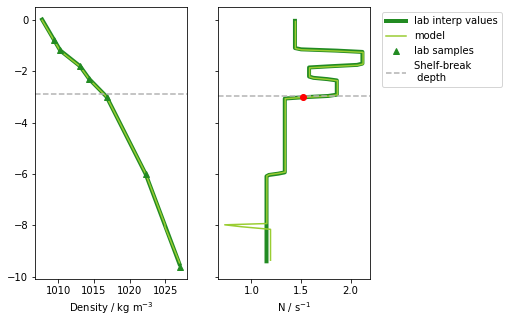

In [8]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(6,5), sharey=True)

ax2.plot(1000*interp_rho, -depth_model, '-',color='forestgreen',linewidth=4,label='lab interp values')
ax2.plot(Rho0_model, 100*RC, '-',color='yellowgreen',label='model')
ax2.plot(1000*df.density1[:], -df.depth, '^',color='forestgreen',label='lab samples')
ax2.axhline(-2.9, color='0.7', linestyle='--', label='Shelf-break \n depth')
ax2.set_xlabel('Density / kg m$^{-3}$')

ax3.plot(N_lab, depthN_lab*100, '-',color='forestgreen',linewidth=4,label='N lab from interp rho')
ax3.plot(N_model, depthN_model*100, '-',color='yellowgreen',label='N model')

ax3.axhline(-depth_model[z_sb_ind], color='0.7', linestyle='--', label='Shelf-break \n depth')

#print(f'Lab N is {N_lab[z_sb_ind]} 1/s at shelf break depth {depthN_lab[z_sb_ind]*100} cm')
#print(f'Model N is {N_model[z_sb_ind]} 1/s at shelf break depth {depthN_model[z_sb_ind]*100} cm')
print('Lab N is %f 1/s at shelf break depth %f cm' %(N_lab[z_sb_ind],depthN_lab[z_sb_ind]*100))
print('Model N is %f 1/s at shelf break depth %f cm' %(N_model[z_sb_ind],depthN_model[z_sb_ind]*100))

ax3.plot(N_lab[z_sb_ind], depthN_lab[z_sb_ind]*100,'ro')
ax3.set_xlabel('N / s$^{-1}$')
ax2.legend(bbox_to_anchor=(3.1,1))

## Density change at canyon head

Conduino measurements vs density at a virtual station (three different depths from the bottom) at the canyons' heads. The virtual station is the average of 4 cells. 

See plot below where probe_ind, axis_ind and axis_ind_dns are defined. Indices of the probes locations are (z_probe_ind, probe_ind, axis_ind) for the upstream canyon and (z_probe_ind, probe_ind, axis_ind_dns) for the downstream canyon.

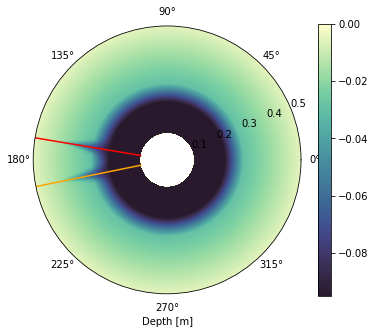

Shelf break radius 
28.792452830188687
probe depth
-1.2250000000000008
Bottom depth at probe location
-1.510969723562966


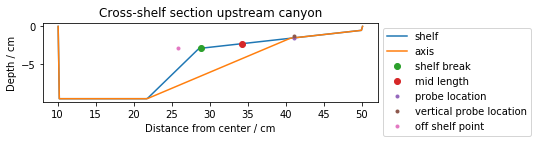

In [9]:
# Depth plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection='polar'),figsize=(6,5))

pcm1 = ax.pcolormesh(Th,R,-grid.Depth,cmap=cmo.cm.deep_r)
cb = plt.colorbar(pcm1,ax=ax)
ax.plot(np.ones_like(R)*Th[axis_ind].data,R[:], color='orange')
ax.plot(np.ones_like(R)*Th[axis_ind_dns].data,R[:], color='red')
ax.set_xlabel(r'Depth [m]')
plt.show()

# Shelf cross-section
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.plot(R*100,-grid.Depth[:,20]*100,'-', label='shelf')
ax.plot(R*100,-grid.Depth[:,axis_ind]*100,'-',label='axis')
ax.plot(R[sb_ind]*100,-grid.Depth[sb_ind,20]*100,'o', label='shelf break')
ax.plot(R[mid_ind]*100,-grid.Depth[mid_ind,20]*100,'o', label='mid length')
ax.plot(R[probe_ind]*100,-grid.Depth[probe_ind,20]*100,'.', label='probe location')
ax.plot(R[probe_ind]*100,grid.RC[z_probe_ind]*100,'.', label='vertical probe location')
ax.plot(R[sb_ind-20]*100,-grid.Depth[sb_ind,20]*100,'.', label='off shelf point')

ax.set_xlabel(r'Distance from center / cm')
ax.set_ylabel(r'Depth / cm')
ax.set_title('Cross-shelf section upstream canyon')
ax.set_aspect(1)
ax.legend(bbox_to_anchor=(1,1))
print('Shelf break radius ') 
print(100*R[sb_ind].data)
print('probe depth')
print(100*grid.RC[z_probe_ind].data)
print('Bottom depth at probe location')
print(-grid.Depth[probe_ind,20].data*100)

In [10]:
# Get density at virtual stations
tslice=slice(0,17)

# Upstream, 3 depths
probe1_rho1 = rho_virtual_probe(state, tslice, z_probe_ind+2, probe_ind, axis_ind, RhoRef)
probe1_rho2 = rho_virtual_probe(state, tslice, z_probe_ind+3, probe_ind, axis_ind, RhoRef)
probe1_rho3 = rho_virtual_probe(state, tslice, z_probe_ind+4, probe_ind, axis_ind, RhoRef)

# Downstream, 3 depths
probe2_rho1 = rho_virtual_probe(state, tslice, z_probe_ind+2, probe_ind, axis_ind_dns, RhoRef)
probe2_rho2 = rho_virtual_probe(state, tslice, z_probe_ind+3, probe_ind, axis_ind_dns, RhoRef)
probe2_rho3 = rho_virtual_probe(state, tslice, z_probe_ind+4, probe_ind, axis_ind_dns, RhoRef)

In [11]:
# Get conduino timeseries

filepath = '../../lab/Conduino/experiments/exp_19dec19/04_experiment.mat'
mat = sio.loadmat(filepath, squeeze_me=True)
P1 = mat['ch1']
P2 = mat['ch2']
time = mat['time']
dens1 = ctools.densANK1_05Dec19(P1)
dens2 = ctools.densANK2_05Dec19(P2)

f0 = (0.7/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
fs = len(time)/np.max(time) # Sampling frequency in Hz
ups_rho_lab = 1000*(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5)) # kg/m^3
dns_rho_lab = 1000*(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5)) # kg/m^3

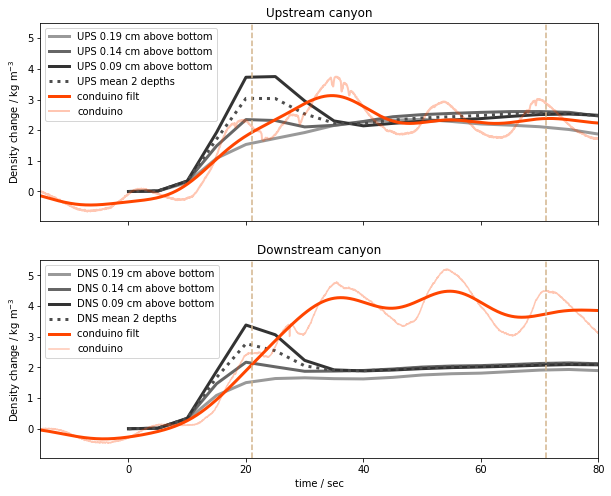

In [12]:
# Plot time series

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8), sharex=True, sharey=True)

time_model = np.arange(17)*5
probe_bot_depth = grid.Depth[probe_ind,axis_ind].data

ax1.plot(time_model,probe1_rho1[:]-probe1_rho1[0], color='0.6',linewidth=3,
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+2])))
ax1.plot(time_model,probe1_rho2[:]-probe1_rho2[0], color='0.4',linewidth=3,
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+3])))
ax1.plot(time_model,probe1_rho3[:]-probe1_rho3[0], color='0.2',linewidth=3,
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))
mean_probe = ((probe1_rho3[:]-probe1_rho3[0])+(probe1_rho2[:]-probe1_rho2[0]))/2
ax1.plot(time_model,mean_probe, color='0.3',linewidth=3,linestyle=':',
        label='UPS mean 2 depths' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))
ax1.plot(time[0:2400]-15, ups_rho_lab, color='orangered', label = 'conduino filt',linewidth=3)
ax1.plot(time[0:2400]-15, 1000*(dens1[0:2400]-dens1[0]), color='orangered',
         label = 'conduino', linewidth=2,alpha=0.3)
ax1.set_title('Upstream canyon')


ax2.plot(time_model,probe2_rho1[:]-probe2_rho1[0], color='0.6', linewidth=3,
        label='DNS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+2])))
ax2.plot(time_model,probe2_rho2[:]-probe2_rho2[0], color='0.4', linewidth=3,
        label='DNS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+3])))
ax2.plot(time_model,probe2_rho3[:]-probe2_rho3[0], color='0.2',linewidth=3,
        label='DNS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))
mean_probe = ((probe2_rho3[:]-probe2_rho3[0])+(probe2_rho2[:]-probe2_rho2[0]))/2
ax2.plot(time_model,mean_probe, color='0.3',linewidth=3,linestyle=':',
        label='DNS mean 2 depths' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))
ax2.plot(time[0:2400]-15, dns_rho_lab, color='orangered', label = 'conduino filt',linewidth=3)
ax2.plot(time[0:2400]-15, 1000*(dens2[0:2400]-dens2[0]), color='orangered', label = 'conduino', alpha=0.3)
ax2.set_title('Downstream canyon')

ax1.axvline(21,linestyle='--', color='tan')
ax1.axvline(71,linestyle='--', color='tan')
ax2.axvline(21,linestyle='--', color='tan')
ax2.axvline(71,linestyle='--', color='tan')

ax2.set_xlim(-15,80)
ax1.set_ylabel(r'Density change / kg m$^{-3}$')
ax2.set_ylabel(r'Density change / kg m$^{-3}$')
ax2.set_xlabel('time / sec')
ax1.legend()
ax2.legend()

The density change at the upstream canyon is very similar when we compare model vs lab. Magnitudes and shape are similar, but lab reaches max change at about 30 sec while the model does so at 20 sec. I fiddled with the body forcing parameters to get the max at 20 so I should go back and change them to get the max at 30 sec.

Maybe it would be good to use the average between the depth levels (0.19 cm and 0.14 cm above the bottom) as a comparison metric -- that is the average between the two darkest lines (dotted, gray line).

The downstream canyon in the model behaves very similar to the upstream canyon, but the conduino timeseries is not so similar. The conduino ts stays high while the model reches a max and then comes down to a lower level.

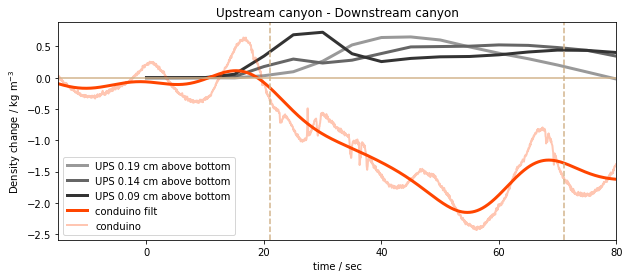

In [13]:
# Plot time series

fig, (ax1) = plt.subplots(1,1,figsize=(10,4), sharex=True, sharey=True)

time_model = np.arange(17)*5
probe_bot_depth = grid.Depth[probe_ind,axis_ind].data

ax1.plot(time_model,(probe1_rho1[:]-probe1_rho1[0])-(probe2_rho1[:]-probe2_rho1[0]), color='0.6',linewidth=3,
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+2])))


ax1.plot(time_model,(probe1_rho2[:]-probe1_rho2[0])-(probe2_rho2[:]-probe2_rho2[0]), color='0.4',linewidth=3,
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+3])))


ax1.plot(time_model,(probe1_rho3[:]-probe1_rho3[0])-(probe2_rho3[:]-probe2_rho3[0]), color='0.2',linewidth=3,
        label='UPS %1.2f cm above bottom' %(100*(probe_bot_depth+grid.RC[z_probe_ind+4])))


ax1.plot(time[0:2400]-15, ups_rho_lab-dns_rho_lab, color='orangered', label = 'conduino filt',linewidth=3)


ax1.plot(time[0:2400]-15, 1000*((dens1[0:2400]-dens1[0])-(dens2[0:2400]-dens2[0])), color='orangered',
         label = 'conduino', linewidth=2,alpha=0.3)
ax1.set_title('Upstream canyon - Downstream canyon')


ax1.axvline(21,linestyle='--', color='tan')
ax1.axvline(71,linestyle='--', color='tan')
ax1.axhline(0,linestyle='-', color='tan')

ax1.set_xlim(-15,80)
ax1.set_ylabel(r'Density change / kg m$^{-3}$')
ax1.set_xlabel('time / sec')
ax1.legend()

The density change is larger in the upstream canyon (slightly) in the model than in the lab. In the lab the density change is larger (5x vs the model) in the downstream canyon. Although, the model result is consitent with the older experiments (pre-defence).

## Incoming flow (forcing)

#### Lab velocties from PIV (horrible code, clean up and make functions or something)

In [14]:
idalia_land = '#8b7765'

# Set file paths
filepath1 = '../../lab/PIV/experiments/exp_19dec19/velocity/T14_run01_piv.mat'
filepath2 = '../../lab/PIV/experiments/exp_19dec19/velocity/T14_run02_piv.mat'
filepath3 = '../../lab/PIV/experiments/exp_19dec19/velocity/T14_run03_piv.mat'

# get masks variables shape is (fr,y,x)

mask1 = get_mask(filepath1) # (y,x)
mask2 = get_mask(filepath2) # (y,x)
mask3 = get_mask(filepath3) # (y,x)

angle = (-15)*np.pi/180  # rot angle piv output

66.12548371317742 18.980923904345243


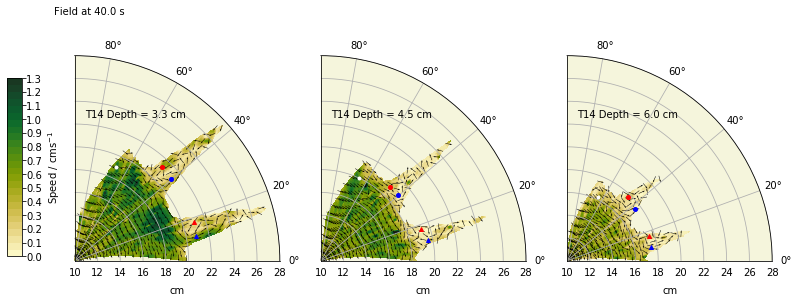

In [142]:
# normalized quiver
max_spd = 1.4
min_spd = 0
cbar_ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
fr = 200
nt = 25
fig = plt.figure(figsize=(12.5,4.5))
ax0 = fig.add_subplot(131, projection='polar')
ax1 = fig.add_subplot(132, projection='polar')
ax2 = fig.add_subplot(133, projection='polar')

ax0.set_facecolor('beige')
ax1.set_facecolor('beige')
ax2.set_facecolor('beige')

# data for frame 
x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)

r1 = ((x_ma1+5)**2+(y_ma1-np.min(y_ma1))**2)**0.5
th1 = np.arctan((y_ma1-np.min(y_ma1))/(x_ma1+5))
ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)

r2 = ((x_ma2+5)**2+(y_ma2-np.min(y_ma2))**2)**0.5
th2 = np.arctan((y_ma2-np.min(y_ma2))/(x_ma2+5))
ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)

r3 = ((x_ma3+5)**2+(y_ma3-np.min(y_ma3))**2)**0.5
th3 = np.arctan((y_ma3-np.min(y_ma3))/(x_ma3+5))
ur3 = (np.cos(th3)*u_ma3)+(np.sin(th3)*v_ma3)
uth3 = ((r3*np.cos(th3)*v_ma3)-(r3*np.sin(th3)*u_ma3))/(r3**2)

# plot data 1
cf = ax0.contourf(th1,r1,spd_ma1,30,
                  cmap=cmo.cm.speed, 
                  vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
cbar_ax = fig.add_axes([0.05, 0.2, 0.016, 0.55])
cb = plt.colorbar(cf, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
cb.ax.yaxis.set_tick_params(pad=1)
cb.set_label('Speed / cms$^{-1}$')

qv = ax0.quiver(th1[::2,::2],r1[::2,::2],
                U1[::2,::2],V1[::2,::2],scale=30, 
                color='k', units='width',pivot='middle')
station = ax0.plot(th1[26,14],r1[26,14],'wo', markersize=3)
print(th1[26,14]*180/np.pi ,r1[26,14])

d1_st_1 = [26,34]
d1_st_2 = [30,40]

ax0.plot(th1[d1_st_1[0],d1_st_1[1]],r1[d1_st_1[0],d1_st_1[1]],'ro', markersize=4)
ax0.plot(th1[d1_st_2[0],d1_st_2[1]],r1[d1_st_2[0],d1_st_2[1]],'bo', markersize=4)

d1_st_3 = [47,56]
d1_st_4 = [53,59]

ax0.plot(th1[d1_st_3[0],d1_st_3[1]],r1[d1_st_3[0],d1_st_3[1]],'r^', markersize=4)
ax0.plot(th1[d1_st_4[0],d1_st_4[1]],r1[d1_st_4[0],d1_st_4[1]],'b^', markersize=4)


# plot data 2
cf = ax1.contourf(th2,r2,spd_ma2,30,
                  cmap=cmo.cm.speed, 
                  vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays

qv = ax1.quiver(th2[::2,::2],r2[::2,::2],
                U2[::2,::2],V2[::2,::2],scale=30, 
                color='k', units='width',pivot='middle')
station = ax1.plot(th2[28,14],r2[28,14],'wo', markersize=3)

d2_st_1 = [32,31]
d2_st_2 = [35,36]

ax1.plot(th1[d2_st_1[0],d2_st_1[1]],r1[d2_st_1[0],d2_st_1[1]],'ro', markersize=4)
ax1.plot(th1[d2_st_2[0],d2_st_2[1]],r1[d2_st_2[0],d2_st_2[1]],'bo', markersize=4)

d2_st_3 = [50,52]
d2_st_4 = [55,56]

ax1.plot(th1[d2_st_3[0],d2_st_3[1]],r1[d2_st_3[0],d2_st_3[1]],'r^', markersize=4)
ax1.plot(th1[d2_st_4[0],d2_st_4[1]],r1[d2_st_4[0],d2_st_4[1]],'b^', markersize=4)

# plot data 3
cf = ax2.contourf(th3,r3,spd_ma3,30,
                  cmap=cmo.cm.speed, 
                  vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays

qv = ax2.quiver(th3[::2,::2],r3[::2,::2],
                U3[::2,::2],V3[::2,::2],scale=30, 
                color='k', units='width',pivot='middle')
station = ax2.plot(th3[32,14],r3[32,14],'wo', markersize=3)

d3_st_1 = [35,30]
d3_st_2 = [40,36]

ax2.plot(th1[d3_st_1[0],d3_st_1[1]],r1[d3_st_1[0],d3_st_1[1]],'ro', markersize=4)
ax2.plot(th1[d3_st_2[0],d3_st_2[1]],r1[d3_st_2[0],d3_st_2[1]],'bo', markersize=4)

d3_st_3 = [53,48]
d3_st_4 = [59,51]

ax2.plot(th1[d3_st_3[0],d3_st_3[1]],r1[d3_st_3[0],d3_st_3[1]],'r^', markersize=4)
ax2.plot(th1[d3_st_4[0],d3_st_4[1]],r1[d3_st_4[0],d3_st_4[1]],'b^', markersize=4)

ax0.text(0.05,.7,'T14 Depth = 3.3 cm',transform=ax0.transAxes)
ax1.text(0.05,.7,'T14 Depth = 4.5 cm',transform=ax1.transAxes)
ax2.text(0.05,.7,'T14 Depth = 6.0 cm',transform=ax2.transAxes)
ax0.text(-0.1,1.2,'Field at %1.1f s' %(fr/5), 
         transform=ax0.transAxes)
ax0.set_xlabel('cm', labelpad=20.0)
ax1.set_xlabel('cm', labelpad=20.0)
ax2.set_xlabel('cm', labelpad=20.0)
ax0.set_rlim(10,28)
ax1.set_rlim(10,28)
ax2.set_rlim(10,28)    
ax0.set_thetalim(0*np.pi/180,90*np.pi/180)
ax1.set_thetalim(0*np.pi/180,90*np.pi/180)
ax2.set_thetalim(0*np.pi/180,90*np.pi/180)
ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)

The white dot shows the station from where I'm getting the velocities at each depth.

In [143]:
# Get ur and uth at stations
nt = 2
frames = np.arange(0,356,nt)
r_vel_1 = np.zeros(np.shape(frames))
r_vel_2 = np.zeros(np.shape(frames))
r_vel_3 = np.zeros(np.shape(frames))

th_vel_1 = np.zeros(np.shape(frames))
th_vel_2 = np.zeros(np.shape(frames))
th_vel_3 = np.zeros(np.shape(frames))

ur_st1_d1 = np.zeros(np.shape(frames))
ur_st2_d1 = np.zeros(np.shape(frames))
ur_st3_d1 = np.zeros(np.shape(frames))
ur_st4_d1 = np.zeros(np.shape(frames))

uth_st1_d1 = np.zeros(np.shape(frames))
uth_st2_d1 = np.zeros(np.shape(frames))
uth_st3_d1 = np.zeros(np.shape(frames))
uth_st4_d1 = np.zeros(np.shape(frames))

ur_st1_d2 = np.zeros(np.shape(frames))
ur_st2_d2 = np.zeros(np.shape(frames))
ur_st3_d2 = np.zeros(np.shape(frames))
ur_st4_d2 = np.zeros(np.shape(frames))

ur_st1_d3 = np.zeros(np.shape(frames))
ur_st2_d3 = np.zeros(np.shape(frames))
ur_st3_d3 = np.zeros(np.shape(frames))
ur_st4_d3 = np.zeros(np.shape(frames))


ii=0
for fr in frames:#600,nt):
    
    #frame data
    x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
    x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
    x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)
    
    r1 = ((x_ma1+5)**2+(y_ma1-np.min(y_ma1))**2)**0.5
    th1 = np.arctan((y_ma1-np.min(y_ma1))/(x_ma1+5))
    ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
    uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)
    
    r2 = ((x_ma2+5)**2+(y_ma2-np.min(y_ma2))**2)**0.5
    th2 = np.arctan((y_ma2-np.min(y_ma2))/(x_ma2+5))
    ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
    uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)
    
    r3 = ((x_ma3+5)**2+(y_ma3-np.min(y_ma3))**2)**0.5
    th3 = np.arctan((y_ma3-np.min(y_ma3))/(x_ma3+5))
    ur3 = (np.cos(th3)*u_ma3)+(np.sin(th3)*v_ma3)
    uth3 = ((r3*np.cos(th3)*v_ma3)-(r3*np.sin(th3)*u_ma3))/(r3**2)
   
    # data st 1
    r_vel_1[ii] = np.mean(ur1[25:27,13:15])
    th_vel_1[ii] = r1[26,14]*np.mean(uth1[25:27,13:15])
    r_st1 = r1[26,14]
    th_st1 = th1[26,14]
    
    ur_st1_d1[ii] = np.nanmean(ur1[d1_st_1[0]-1:d1_st_1[0]+1,d1_st_1[1]-1:d1_st_1[1]+1])
    uth_st1_d1[ii] = r1[d1_st_1[0],d1_st_1[1]]*np.nanmean(uth1[d1_st_1[0]-1:d1_st_1[0]+1,d1_st_1[1]-1:d1_st_1[1]+1])
    
    ur_st2_d1[ii] = np.nanmean(ur1[d1_st_2[0]-1:d1_st_2[0]+1,d1_st_2[1]-1:d1_st_2[1]+1])
    uth_st2_d1[ii] = r1[d1_st_2[0],d1_st_2[1]]*np.nanmean(uth1[d1_st_2[0]-1:d1_st_2[0]+1,d1_st_2[1]-1:d1_st_2[1]+1])
    
    ur_st3_d1[ii] = np.nanmean(ur1[d1_st_3[0]-1:d1_st_3[0]+1,d1_st_3[1]-1:d1_st_3[1]+1])
    uth_st3_d1[ii] = r1[d1_st_3[0],d1_st_3[1]]*np.nanmean(uth1[d1_st_3[0]-1:d1_st_3[0]+1,d1_st_3[1]-1:d1_st_3[1]+1])
    
    ur_st4_d1[ii] = np.nanmean(ur1[d1_st_4[0]-1:d1_st_4[0]+1,d1_st_4[1]-1:d1_st_4[1]+1])
    uth_st4_d1[ii] = r1[d1_st_4[0],d1_st_4[1]]*np.nanmean(uth1[d1_st_4[0]-1:d1_st_4[0]+1,d1_st_4[1]-1:d1_st_4[1]+1])
    
    # data depth 2
    r_vel_2[ii] = np.mean(ur2[27:29,13:15])
    th_vel_2[ii] = r2[28,14]*np.mean(uth2[27:29,13:15])
    r_st2 = r2[28,14]
    th_st2 = th2[28,14]
    
    ur_st1_d2[ii] = np.nanmean(ur1[d2_st_1[0]-1:d2_st_1[0]+1,d2_st_1[1]-1:d2_st_1[1]+1])
    ur_st2_d2[ii] = np.nanmean(ur1[d2_st_2[0]-1:d2_st_2[0]+1,d2_st_2[1]-1:d2_st_2[1]+1])
    ur_st3_d2[ii] = np.nanmean(ur1[d2_st_3[0]-1:d2_st_3[0]+1,d2_st_3[1]-1:d2_st_3[1]+1])
    ur_st4_d2[ii] = np.nanmean(ur1[d2_st_4[0]-1:d2_st_4[0]+1,d2_st_4[1]-1:d2_st_4[1]+1])
    
    # data depth 3
    r_vel_3[ii] = np.mean(ur3[31:33,13:15])
    th_vel_3[ii] = r3[32,14]*np.mean(uth3[31:33,13:15])
    r_st3 = r3[32,14]
    th_st3 = th3[32,14]
    
    ur_st1_d3[ii] = np.nanmean(ur1[d3_st_1[0]-1:d3_st_1[0]+1,d3_st_1[1]-1:d3_st_1[1]+1])
    ur_st2_d3[ii] = np.nanmean(ur1[d3_st_2[0]-1:d3_st_2[0]+1,d3_st_2[1]-1:d3_st_2[1]+1])
    ur_st3_d3[ii] = np.nanmean(ur1[d3_st_3[0]-1:d3_st_3[0]+1,d3_st_3[1]-1:d3_st_3[1]+1])
    ur_st4_d3[ii] = np.nanmean(ur1[d3_st_4[0]-1:d3_st_4[0]+1,d3_st_4[1]-1:d3_st_4[1]+1])

    print(fr,r_vel_1[ii],th_vel_1[ii],r_vel_2[ii],th_vel_2[ii],r_vel_3[ii],th_vel_3[ii])
    ii=ii+1

0 -0.01043214331457823 0.008128696574765818 -0.005809582981326483 -0.0364934224622643 -0.03795970636760185 0.05074526070476229
2 0.014459458149141333 -0.008490728615665522 -0.009702699554741583 -0.14160644604375305 0.009463768152007588 0.0641955116073337
4 -0.04172433296150728 -0.12716370175131866 0.0032351766412953113 -0.02146504075733692 0.024591095408366667 -0.016850705222409924
6 0.0011030589810923771 -0.10336348055665064 0.007940388184758538 -0.08072148977225498 -0.016155187406388657 -0.029797380615154984
8 -0.000497123086340691 -0.06496922404387079 0.004214264733022336 -0.1597764400386523 0.06127009059658244 0.05125644466831378
10 -2.1404814032397954e-05 0.08939062874414111 0.02260666116683797 -0.09914287886971576 0.0654411228596778 -0.015420976473563467
12 -0.025769030520041786 -0.026898673269101583 -0.0676953800213884 -0.04810651453155057 -0.039593457732880775 0.010861631188107559
14 -0.12143592883789303 -0.03259158785586752 0.003618614704261693 -0.11626312308965894 -0.02996626

128 -0.02727548485818121 -0.9194469711234321 -0.06294815484460926 -0.683259908424803 -0.1496675434064621 -0.25403756589010645
130 -0.17211115920422793 -0.6085300835142197 -0.09444330388660763 -0.6338977085578911 -0.17640917670541748 -0.4923572609657601
132 -0.07269170448110765 -0.7776462695556042 -0.09529679005188371 -0.36220733246726217 -0.06517174040787149 -0.3954879047660556
134 0.10413926212354441 -0.5039479082648699 -0.07973407536230863 -0.5955878813206525 -0.07539642367681954 -0.35230242951773155
136 -0.04743644920508648 -0.7266893597717378 -0.12247069290823019 -0.4818655468844662 -0.08058473186714118 -0.45053178907463765
138 -0.03984573506112078 -0.7412562975998314 -0.1441751335092608 -0.5783125823424197 -0.1444584112722087 -0.6302487428387842
140 -0.06353378654320407 -0.5420036408187817 -0.01725655666940814 -0.576022991722023 -0.03432981389057494 -0.6112832555723461
142 -0.14738937005583336 -0.6707343849165903 -0.03426333955965379 -0.7625824881760895 -0.06454640287312471 -0.092

258 -0.12487571210654896 -0.4984638426119354 -0.0032800830299804587 -0.6547034451677145 -0.10511437007403346 -0.12956841563132113
260 -0.25142576200801964 -0.9428644755034572 -0.008815827636067322 -0.7052156468081248 -0.07340190837763357 -0.21302675894536263
262 -0.24169307453472821 -0.9108543523270719 0.037598651778765105 -0.6574270399195195 -0.008598976743452915 -0.3513259540119689
264 -0.1953108676213341 -0.8367582684403999 -0.055365246312820006 -0.6628875765688961 -0.07052989545390165 -0.34043727564004805
266 -0.2872068619352388 -0.9493664590381097 -0.06403289192669956 -0.6469106590879101 -0.13386367783334716 -0.34050635730012574
268 -0.2932583790837085 -0.8287247085412204 -0.14461262247618648 -0.7147599697133576 0.04872301517376926 -0.34515954294017065
270 -0.29257708381267117 -0.7149621985267817 -0.018268035482670503 -0.7391563007364421 -0.03694076060434443 -0.126379038467961
272 -0.2654462145964903 -0.7262059555272488 -0.1734013991894664 -0.7378044634007123 -0.0815414891764765 -

Text(0.5, 1.0, 'Magnitude of azimuthal velocity at upstream slope stations (Exp T14)')

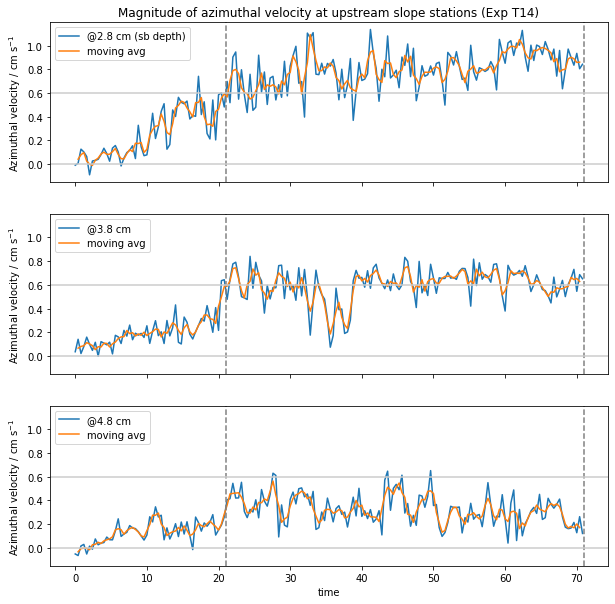

In [144]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

times = frames[0:356]/5

ma_th_vel_1 = (th_vel_1[2:]+th_vel_1[1:-1]+th_vel_1[0:-2])/3
ma_th_vel_2 = (th_vel_2[2:]+th_vel_2[1:-1]+th_vel_2[0:-2])/3
ma_th_vel_3 = (th_vel_3[2:]+th_vel_3[1:-1]+th_vel_3[0:-2])/3

ax0.plot(times,-th_vel_1,label='@2.8 cm (sb depth)')
ax0.plot(times[1:-1],-ma_th_vel_1,label='moving avg')

ax1.plot(times,-th_vel_2,label='@3.8 cm ')
ax1.plot(times[1:-1],-ma_th_vel_2,label='moving avg')

ax2.plot(times,-th_vel_3,label='@4.8 cm ')
ax2.plot(times[1:-1],-ma_th_vel_3,label='moving avg')

ax2.set_xlabel('time')
ax0.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')
ax2.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')

for ax in [ax0,ax1,ax2]:
    ax.legend()
    ax.axvline(21, color='0.5', linestyle='--')
    ax.axvline(71, color='0.5', linestyle='--')
    ax.axhline(0,color='0.8')
    ax.axhline(0.6,color='0.8')
ax0.set_title('Magnitude of azimuthal velocity at upstream slope stations (Exp T14)')

#### Model velocity

time = 45 s


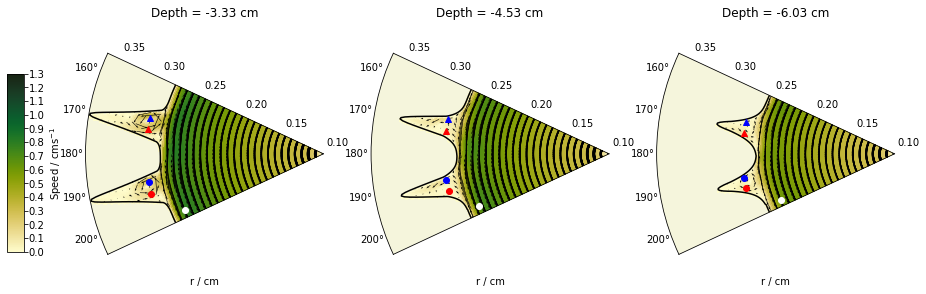

In [145]:
fig = plt.figure(figsize=(14.5,4.5))
ax0 = fig.add_subplot(131, projection='polar')
ax1 = fig.add_subplot(132, projection='polar')
ax2 = fig.add_subplot(133, projection='polar')

ax0.set_facecolor('beige')
ax1.set_facecolor('beige')
ax2.set_facecolor('beige')

nz1 = int(33/0.5)
nz2 = int(45/0.5)
nz3 = int(60/0.5)
tt = 9
thmesh, rmesh = np.meshgrid(Th,R)

# depth 3.3 cm
thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz1,:,:].data,state.V[tt,nz1,:,:].data)
thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz1,:,:]))
rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz1,:,:]))
    
ux = rvel*np.cos(thmesh)-rmesh*np.sin(thmesh)*(-thvel/(rmesh))# minus is MITgcm convention
uy = rvel*np.sin(thmesh)+rmesh*np.cos(thmesh)*(-thvel/(rmesh)) 
spd = np.sqrt(ux**2+uy**2)
pcm1 = ax0.pcolormesh(Th,R,1E2*spd,cmap=cmo.cm.speed, vmin=0, vmax=1.3)
cbar_ax = fig.add_axes([0.05, 0.2, 0.016, 0.55])
cb = plt.colorbar(pcm1, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
cb.ax.yaxis.set_tick_params(pad=1)
cb.set_label('Speed / cms$^{-1}$')
ax0.contour(Th,R,grid.Depth.data,levels=[0.033],colors='k')
qv = ax0.quiver(thmesh[::5,::5],rmesh[::5,::5],
                ux[::5,::5],uy[::5,::5],scale=0.04, 
                color='k', units='width',pivot='middle')
ri_st1 = 110
thi_st1 = 310
ax0.plot(Th[thi_st1], R[ri_st1], 'wo')

r1_dns1 = 130
th1_dns1 = 277
ax0.plot(Th[th1_dns1], R[r1_dns1], 'bo')

r1_ups1 = 130
th1_ups1 = 287
ax0.plot(Th[th1_ups1], R[r1_ups1], 'ro')

r1_dns2 = 130
th1_dns2 = 222
ax0.plot(Th[th1_dns2], R[r1_dns2], 'b^')

r1_ups2 = 130
th1_ups2 = 232
ax0.plot(Th[th1_ups2], R[r1_ups2], 'r^')

# depth 4.5 cm
thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz2,:,:].data,state.V[tt,nz2,:,:].data)
thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz2,:,:]))
rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz2,:,:]))
    
ux = rvel*np.cos(thmesh)-rmesh*np.sin(thmesh)*(-thvel/(rmesh))# minus is MITgcm convention
uy = rvel*np.sin(thmesh)+rmesh*np.cos(thmesh)*(-thvel/(rmesh)) 
spd = np.sqrt(ux**2+uy**2)
pcm2 = ax1.pcolormesh(Th,R,1E2*spd,cmap=cmo.cm.speed, vmin=0, vmax=1.3)
ax1.contour(Th,R,grid.Depth.data,levels=[0.045],colors='k')
qv = ax1.quiver(thmesh[::5,::5],rmesh[::5,::5],
                ux[::5,::5],uy[::5,::5],scale=0.04, 
                color='k', units='width',pivot='middle')

ri_st2 = 103
thi_st2 = 310
ax1.plot(Th[thi_st2], R[ri_st2], 'wo')

r2_dns1 = 121
th2_dns1 = 277
ax1.plot(Th[th2_dns1], R[r2_dns1], 'bo')

r2_ups1 = 121
th2_ups1 = 287
ax1.plot(Th[th2_ups1], R[r2_ups1], 'ro')

r2_dns2 = 121
th2_dns2 = 221
ax1.plot(Th[th2_dns2], R[r2_dns2], 'b^')

r2_ups2 = 121
th2_ups2 = 232
ax1.plot(Th[th2_ups2], R[r2_ups2], 'r^')

# depth 6.0 cm
thvel_nomask, rvel_nomask = unstagger(state.U[tt,nz3,:,:].data,state.V[tt,nz3,:,:].data)
thvel = np.fliplr(np.ma.masked_array(thvel_nomask,mask=maskC[nz3,:,:]))
rvel = np.fliplr(np.ma.masked_array(rvel_nomask,mask=maskC[nz3,:,:]))
    
ux = rvel*np.cos(thmesh)-rmesh*np.sin(thmesh)*(-thvel/(rmesh))# minus is MITgcm convention
uy = rvel*np.sin(thmesh)+rmesh*np.cos(thmesh)*(-thvel/(rmesh)) 
spd = np.sqrt(ux**2+uy**2)
pcm3 = ax2.pcolormesh(Th,R,1E2*spd,cmap=cmo.cm.speed, vmin=0, vmax=1.3)
ax2.contour(Th,R,grid.Depth.data,levels=[0.06],colors='k')
qv = ax2.quiver(thmesh[::5,::5],rmesh[::5,::5],
                ux[::5,::5],uy[::5,::5],scale=0.04, 
                color='k', units='width',pivot='middle')
ri_st3 = 90
thi_st3 = 310
ax2.plot(Th[thi_st3], R[ri_st3], 'wo')

r3_dns1 = 112
th3_dns1 = 277
ax2.plot(Th[th3_dns1], R[r3_dns1], 'bo')

r3_ups1 = 112
th3_ups1 = 287
ax2.plot(Th[th3_ups1], R[r3_ups1], 'ro')

r3_dns2 = 112
th3_dns2 = 221
ax2.plot(Th[th3_dns2], R[r3_dns2], 'b^')

r3_ups2 = 112
th3_ups2 = 232
ax2.plot(Th[th3_ups2], R[r3_ups2], 'r^')
ax0.set_xlabel(r'r / cm')
ax0.set_title('Depth = %1.2f cm'%(100*grid.RC[nz1]))
ax1.set_xlabel(r'r / cm')
ax1.set_title('Depth = %1.2f cm'%(100*grid.RC[nz2]))
ax2.set_xlabel(r'r / cm')
ax2.set_title('Depth = %1.2f cm'%(100*grid.RC[nz3]))
ax0.set_aspect(1)
ax0.set_xlim(np.pi*155/180,np.pi*205/180)
ax0.set_ylim(0.1,0.365)
ax1.set_aspect(1)
ax1.set_xlim(np.pi*155/180,np.pi*205/180)
ax1.set_ylim(0.1,0.365)
ax2.set_aspect(1)
ax2.set_xlim(np.pi*155/180,np.pi*205/180)
ax2.set_ylim(0.1,0.365)

#ax0.set_theta_offset((-np.pi*155)/180)
print('time = %1.0f s' %(tt*5))    
plt.show()

In [146]:
thvel_d1, rvel_d1 = unstagger(state.U[:,nz1,ri_st1-2:ri_st1+2,thi_st1-2:thi_st1+3].data,
                              state.V[:,nz1,ri_st1-2:ri_st1+3,thi_st1-2:thi_st1+2].data)
thvel_d2, rvel_d2 = unstagger(state.U[:,nz2,ri_st2-2:ri_st2+2,thi_st2-2:thi_st2+3].data,
                              state.V[:,nz2,ri_st2-2:ri_st2+3,thi_st2-2:thi_st2+2].data)
thvel_d3, rvel_d3 = unstagger(state.U[:,nz3,ri_st3-2:ri_st3+2,thi_st3-2:thi_st3+3].data,
                              state.V[:,nz3,ri_st3-2:ri_st3+3,thi_st3-2:thi_st3+2].data)

In [147]:
thvel_d1_mean = np.nanmean(np.nanmean(thvel_d1, axis=1), axis=1)
thvel_d2_mean = np.nanmean(np.nanmean(thvel_d2, axis=1), axis=1)
thvel_d3_mean = np.nanmean(np.nanmean(thvel_d3, axis=1), axis=1)

rvel_d1_mean = np.nanmean(np.nanmean(rvel_d1, axis=1), axis=1)
rvel_d2_mean = np.nanmean(np.nanmean(rvel_d2, axis=1), axis=1)
rvel_d3_mean = np.nanmean(np.nanmean(rvel_d3, axis=1), axis=1)

Text(0.5, 1.0, 'Magnitude of azimuthal velocity at upstream slope stations - model vs lab')

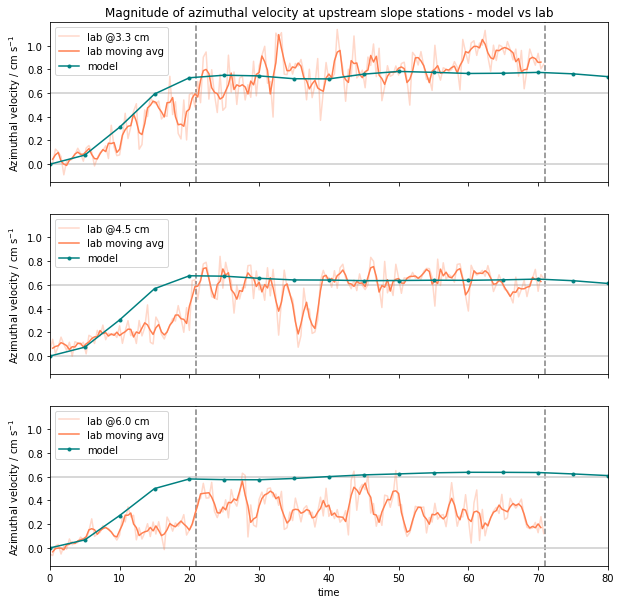

In [148]:
# Plot model vs lab 
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

times = frames[0:356]/5

ma_th_vel_1 = (th_vel_1[2:]+th_vel_1[1:-1]+th_vel_1[0:-2])/3
ma_th_vel_2 = (th_vel_2[2:]+th_vel_2[1:-1]+th_vel_2[0:-2])/3
ma_th_vel_3 = (th_vel_3[2:]+th_vel_3[1:-1]+th_vel_3[0:-2])/3

for ax in [ax0,ax1,ax2]:
    ax.axvline(21, color='0.5', linestyle='--')
    ax.axvline(71, color='0.5', linestyle='--')
    ax.axhline(0,color='0.8')
    ax.axhline(0.6,color='0.8')

ax0.plot(times,-th_vel_1, color='coral', alpha=0.3,label='lab @3.3 cm')
ax0.plot(times[1:-1],-ma_th_vel_1,color='coral',label='lab moving avg')
ax0.plot(np.arange(17)*5,100*thvel_d1_mean,'.-',color='teal',label='model')

ax1.plot(times,-th_vel_2, color='coral', alpha=0.3,label='lab @4.5 cm ')
ax1.plot(times[1:-1],-ma_th_vel_2,color='coral',label='lab moving avg')
ax1.plot(np.arange(17)*5,100*thvel_d2_mean,'.-',color='teal',label='model')

ax2.plot(times,-th_vel_3, color='coral', alpha=0.3, label='lab @6.0 cm ')
ax2.plot(times[1:-1],-ma_th_vel_3,color='coral',label='lab moving avg')
ax2.plot(np.arange(17)*5,100*thvel_d3_mean,'.-',color='teal',label='model')


ax2.set_xlabel('time')
ax0.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')
ax2.set_ylabel(r'Azimuthal velocity / cm s$^{-1}$')

for ax in [ax0,ax1,ax2]:
    ax.legend()
    ax.set_xlim(0,80)
ax0.set_title('Magnitude of azimuthal velocity at upstream slope stations - model vs lab')

Text(0.5, 1.0, 'Magnitude of radial velocity at upstream slope stations - model vs lab')

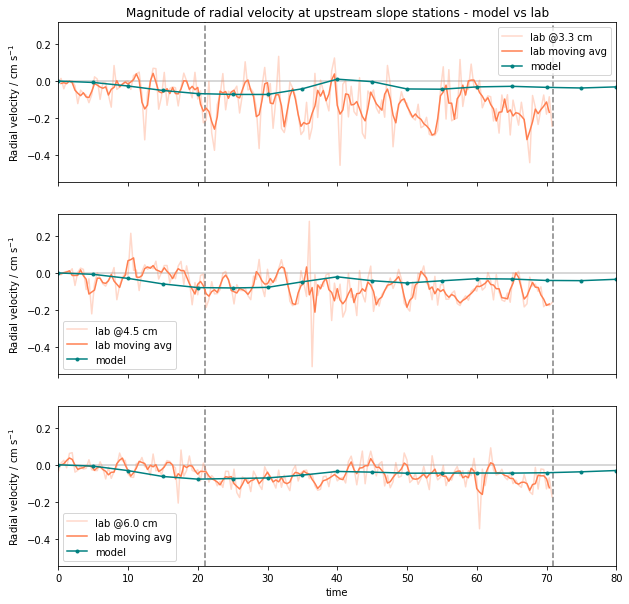

In [149]:
# Plot model vs lab 
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

times = frames[0:356]/5

ma_r_vel_1 = (r_vel_1[2:]+r_vel_1[1:-1]+r_vel_1[0:-2])/3
ma_r_vel_2 = (r_vel_2[2:]+r_vel_2[1:-1]+r_vel_2[0:-2])/3
ma_r_vel_3 = (r_vel_3[2:]+r_vel_3[1:-1]+r_vel_3[0:-2])/3

for ax in [ax0,ax1,ax2]:
    ax.axvline(21, color='0.5', linestyle='--')
    ax.axvline(71, color='0.5', linestyle='--')
    ax.axhline(0,color='0.8')

ax0.plot(times,r_vel_1, color='coral', alpha=0.3,label='lab @3.3 cm')
ax0.plot(times[1:-1],ma_r_vel_1,color='coral',label='lab moving avg')
ax0.plot(np.arange(17)*5,100*rvel_d1_mean,'.-',color='teal',label='model')

ax1.plot(times,r_vel_2, color='coral', alpha=0.3,label='lab @4.5 cm ')
ax1.plot(times[1:-1],ma_r_vel_2,color='coral',label='lab moving avg')
ax1.plot(np.arange(17)*5,100*rvel_d2_mean,'.-',color='teal',label='model')

ax2.plot(times,r_vel_3, color='coral', alpha=0.3, label='lab @6.0 cm ')
ax2.plot(times[1:-1],ma_r_vel_3,color='coral',label='lab moving avg')
ax2.plot(np.arange(17)*5,100*rvel_d3_mean,'.-',color='teal',label='model')


ax2.set_xlabel('time')
ax0.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax2.set_ylabel(r'Radial velocity / cm s$^{-1}$')

for ax in [ax0,ax1,ax2]:
    ax.legend()
    ax.set_xlim(0,80)
ax0.set_title('Magnitude of radial velocity at upstream slope stations - model vs lab')

### Velocity Snapshots

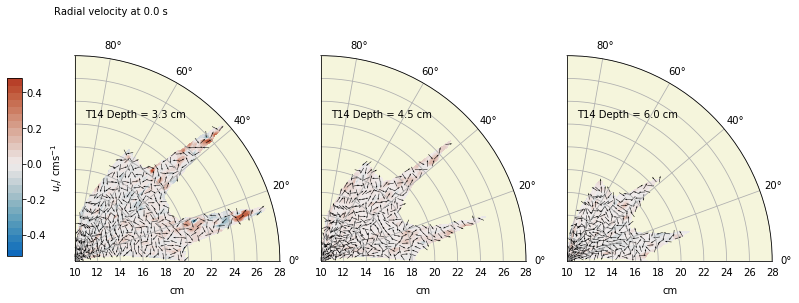

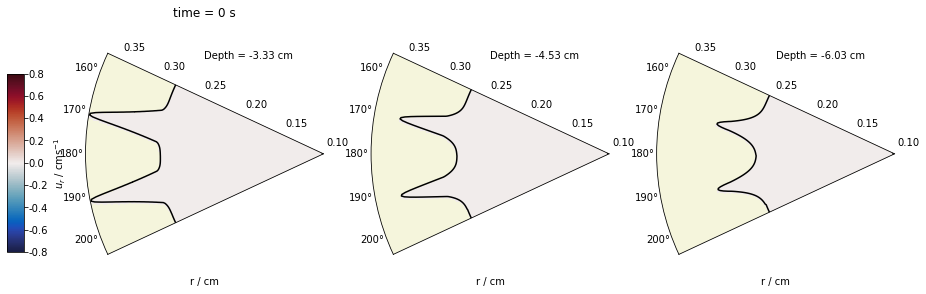

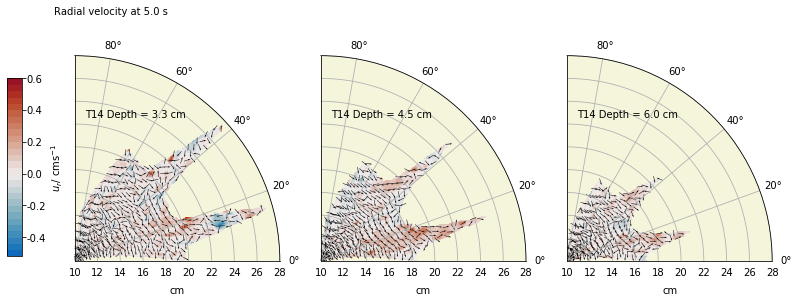

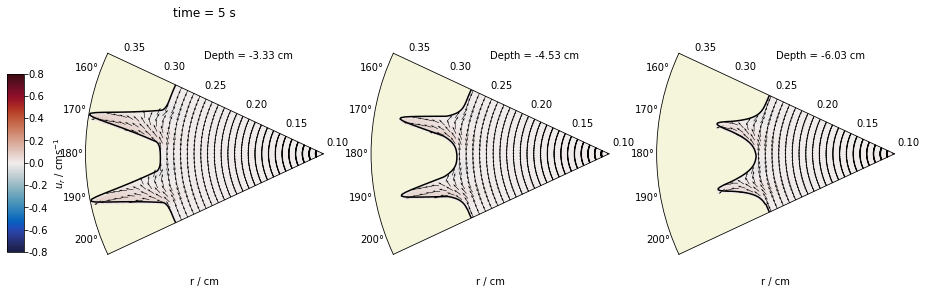

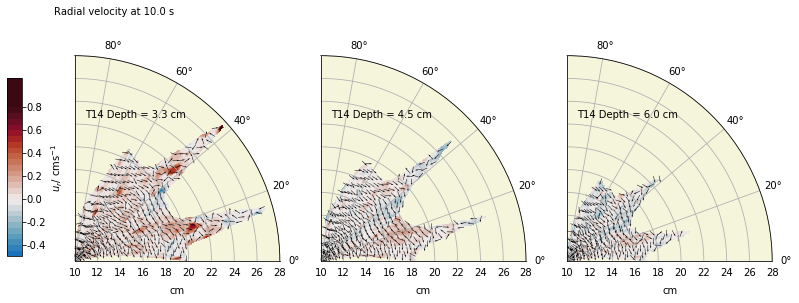

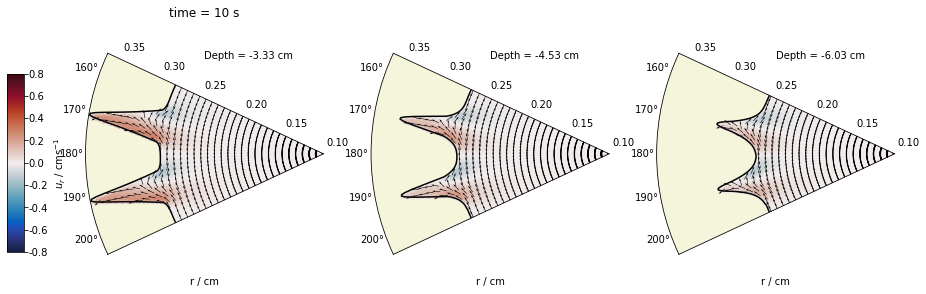

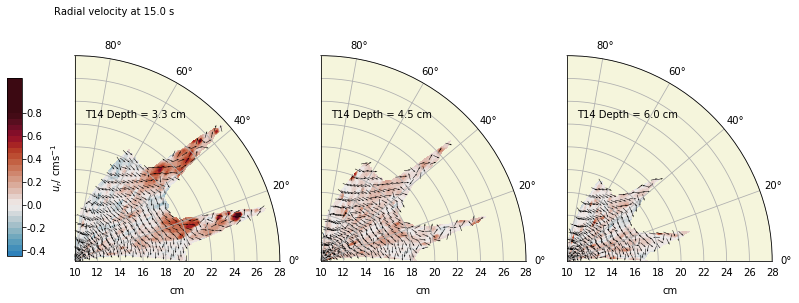

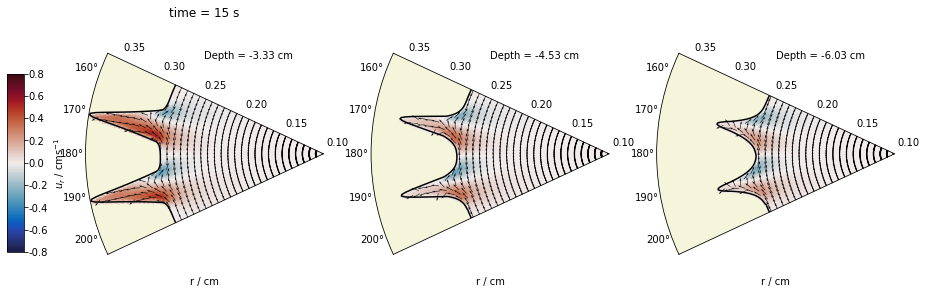

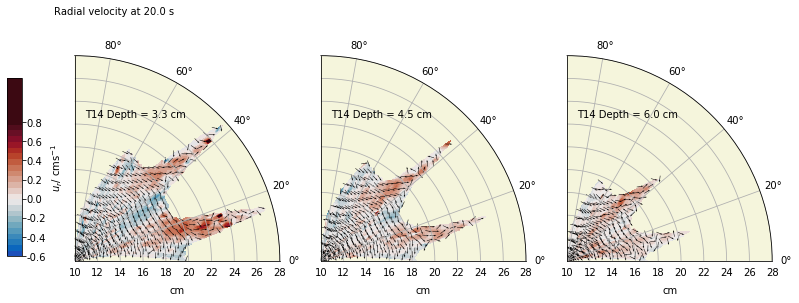

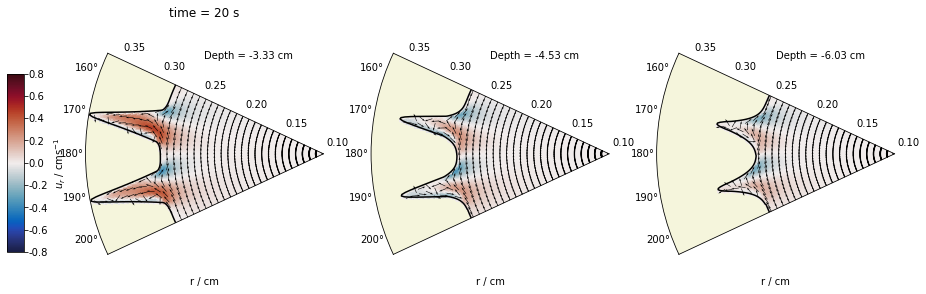

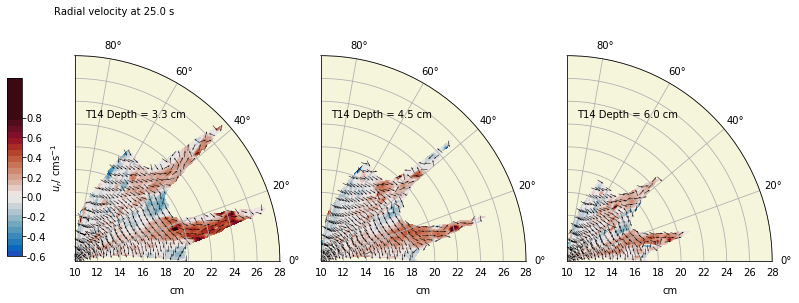

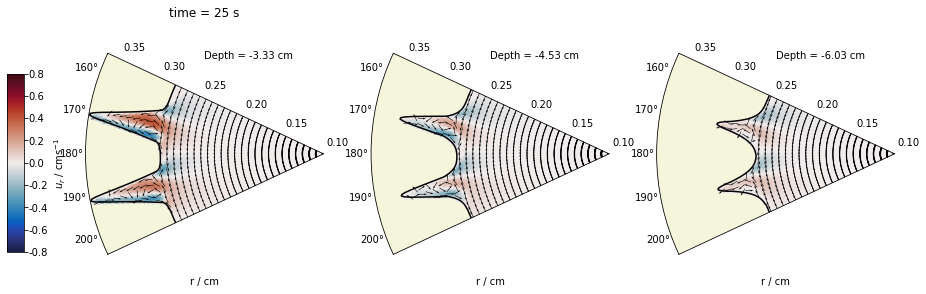

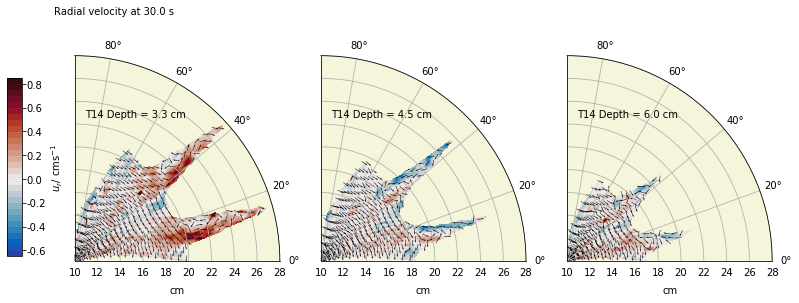

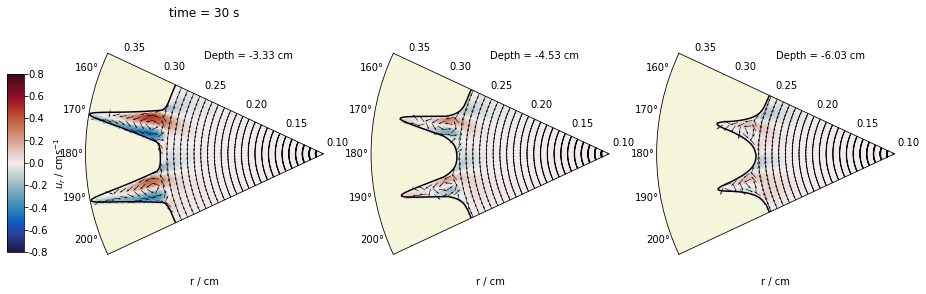

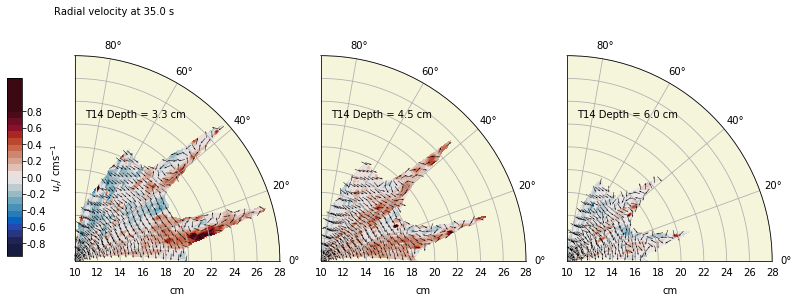

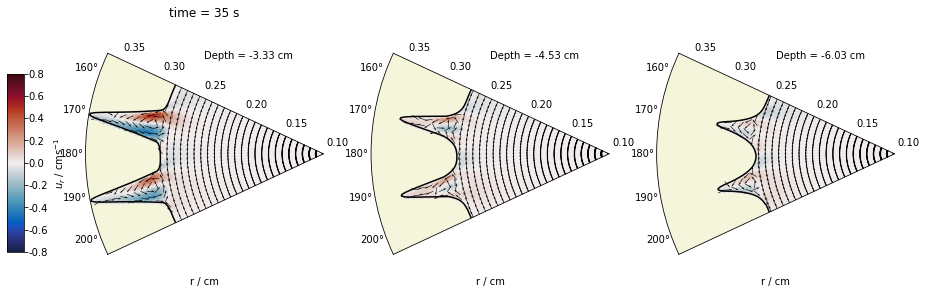

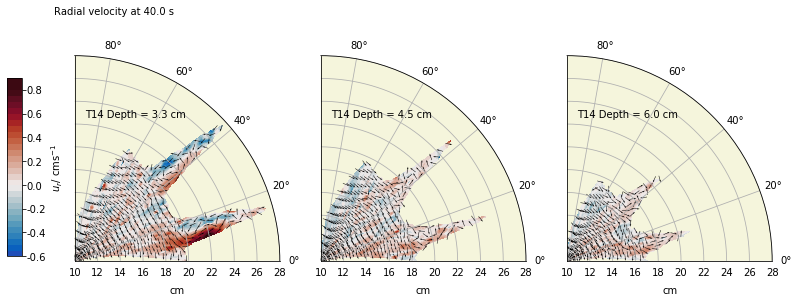

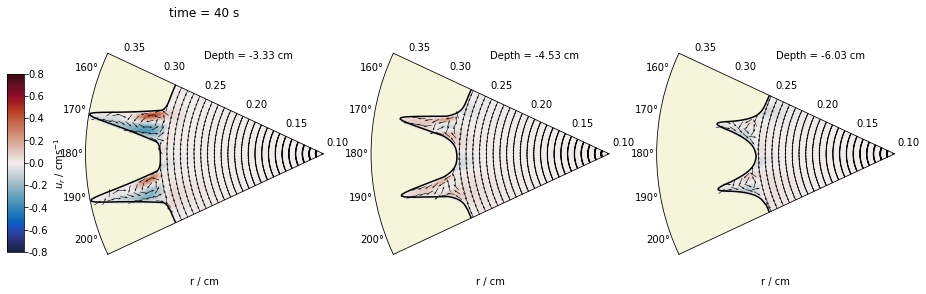

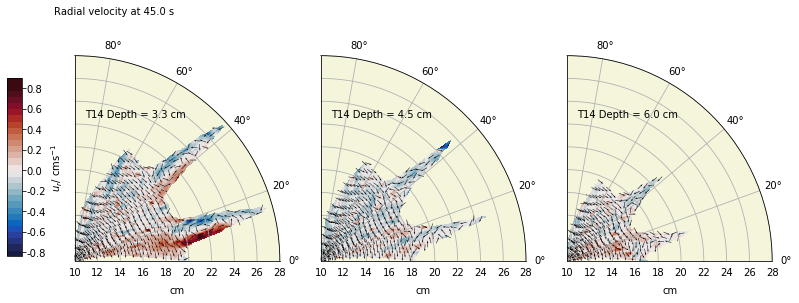

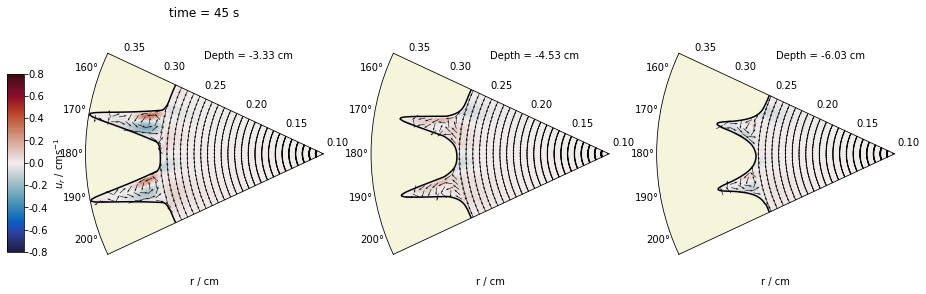

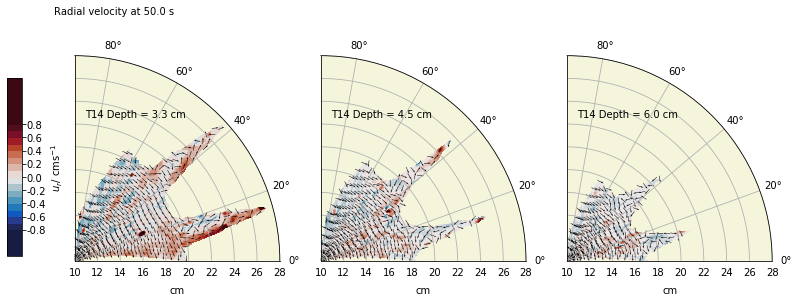

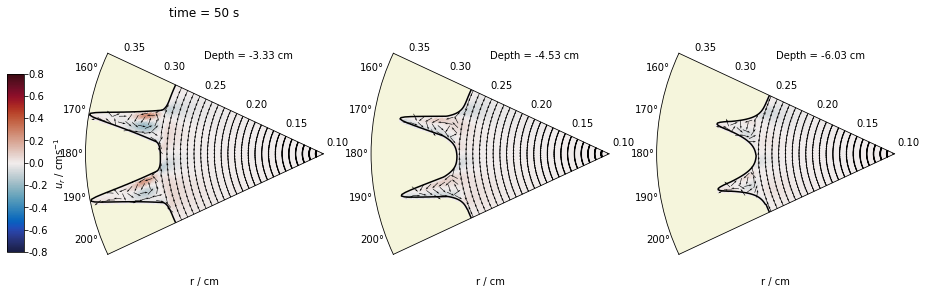

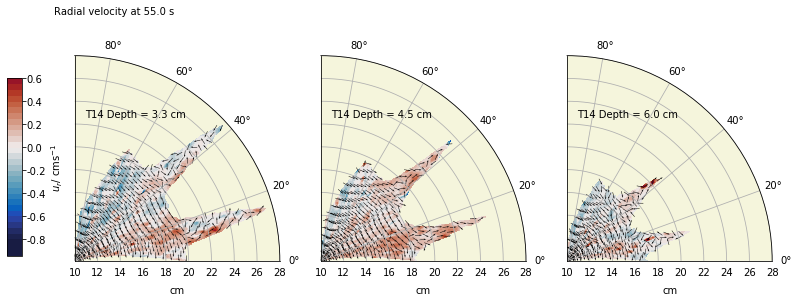

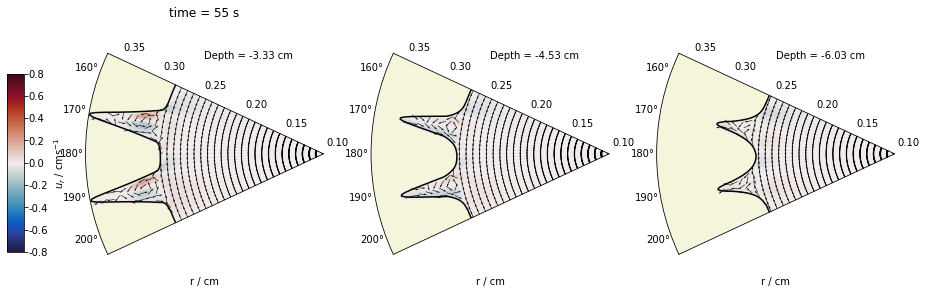

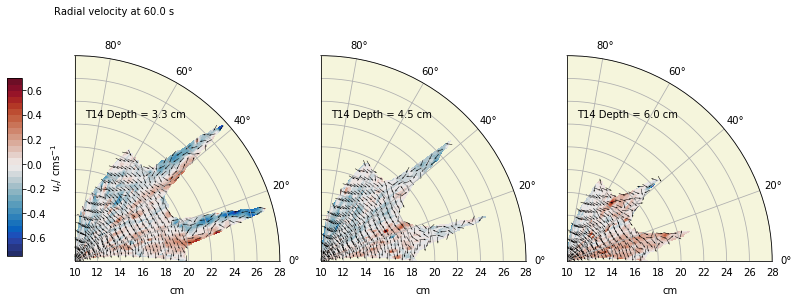

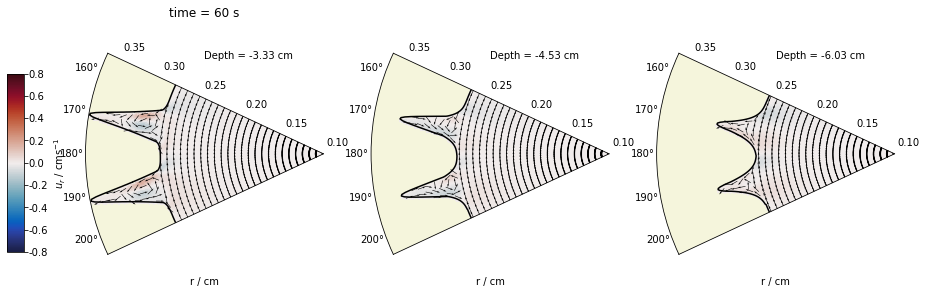

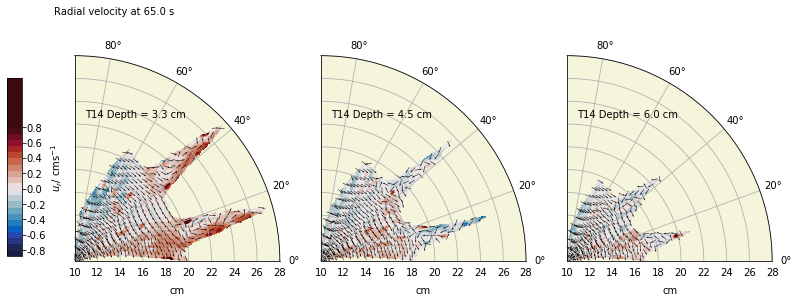

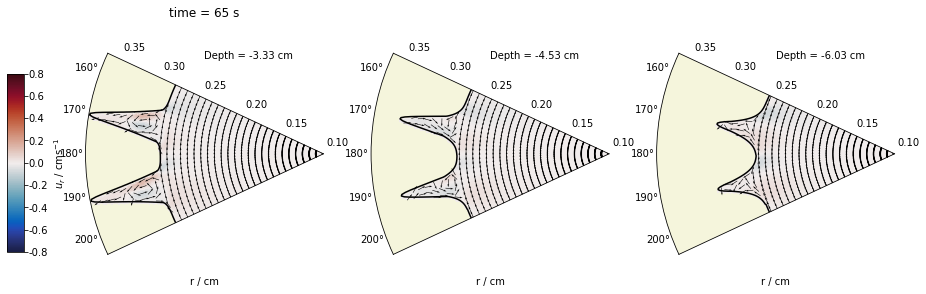

In [150]:
# Normalized quivers
max_spd =0.8
min_spd = -0.8
cbar_ticks = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]
nt = 25
frames = np.arange(0,350,nt) # 14 plots

nz1 = int(33/0.5)
nz2 = int(45/0.5)
nz3 = int(60/0.5)
times = range(14)
thmesh, rmesh = np.meshgrid(Th,R)

for tt, fr in zip(times,frames):
    fig_lab, ax0, ax1, ax2 = plot_lab_rad_vel(max_spd, min_spd, cbar_ticks, fr, mode='snap')
    plt.show()
    fig_model, ax0m, ax1m, ax2m,ur_ups_1, ur_dns_1, ur_ups_2, ur_dns_2,ur2_ups_1, ur2_dns_1, ur2_ups_2, ur2_dns_2,ur3_ups_1, ur3_dns_1, ur3_ups_2, ur3_dns_2= plot_model_rad_vel(tt, thmesh, rmesh,
                                                                                                                                                                                 nz1, nz2, nz3, min_spd, 
                                                                                                                                                                                 max_spd, cbar_ticks)
    
    plt.show()

### Mean radial velocity from PIV, snapshots from model

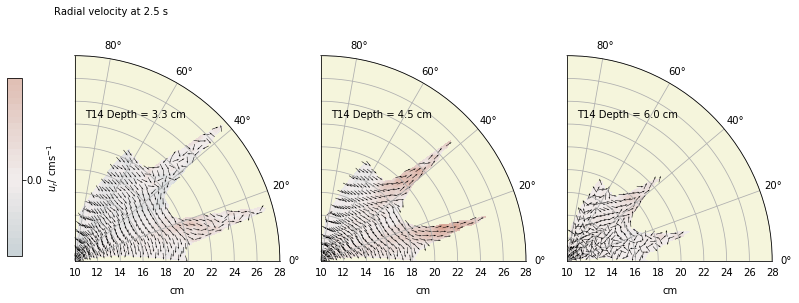

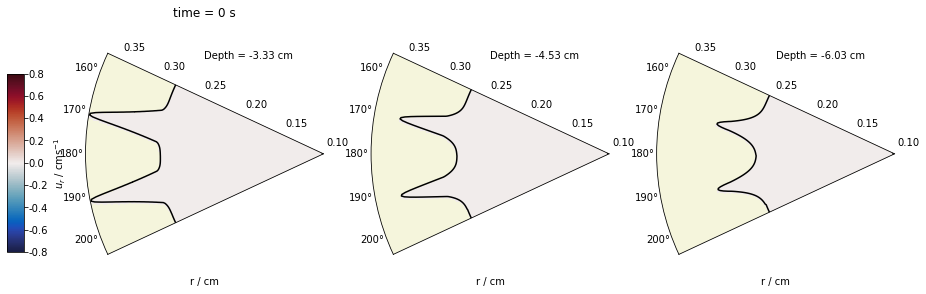

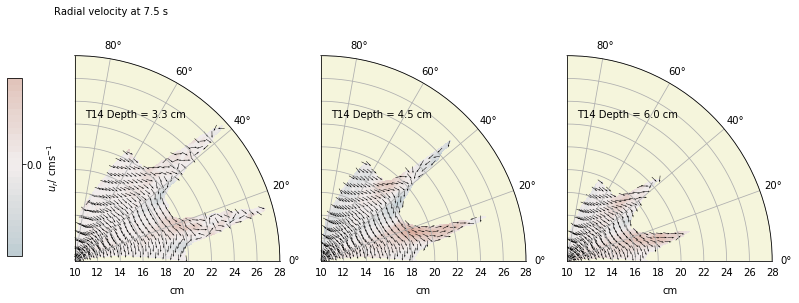

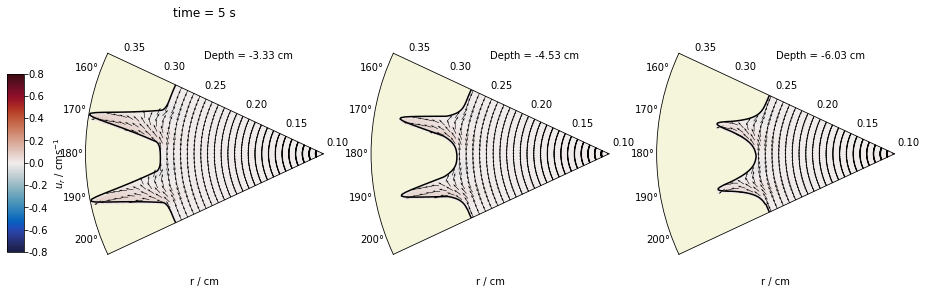

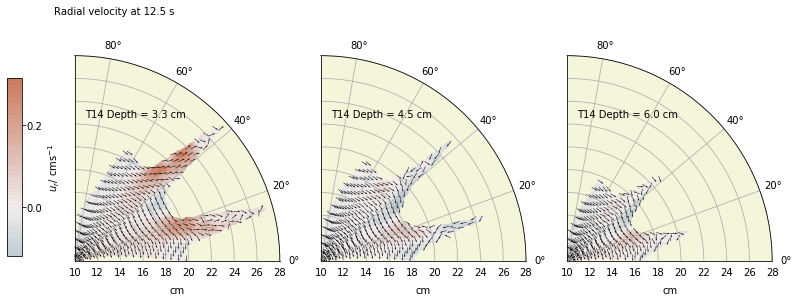

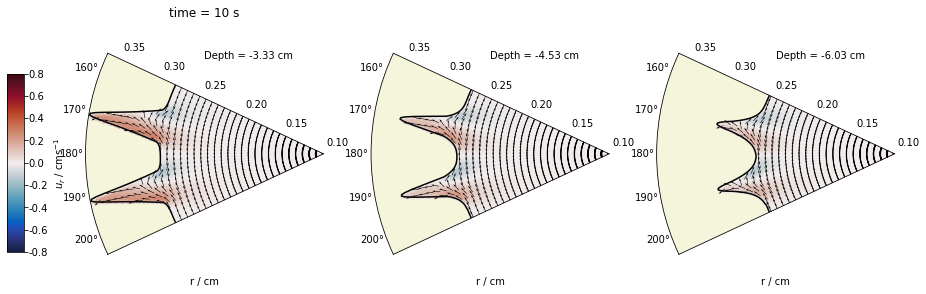

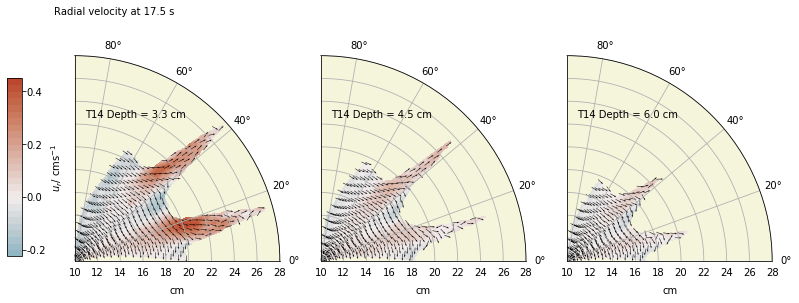

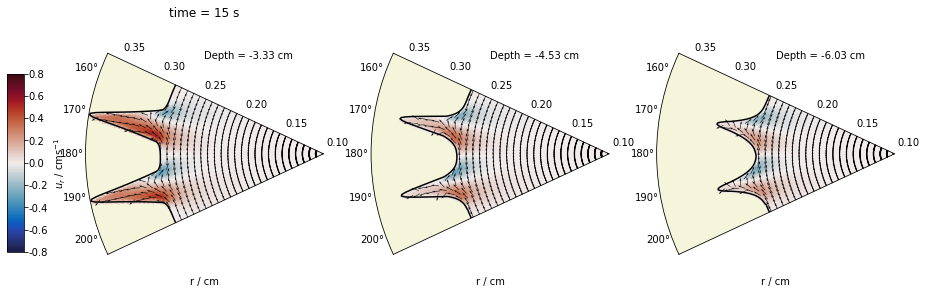

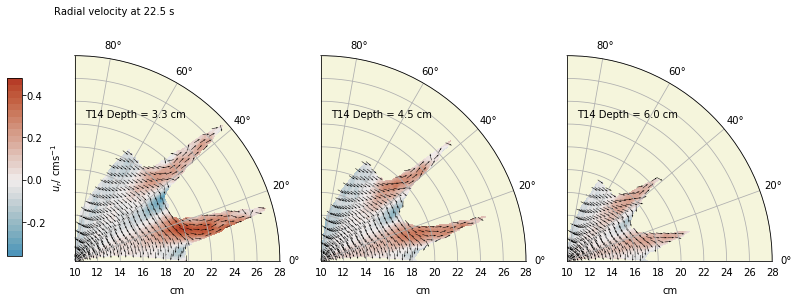

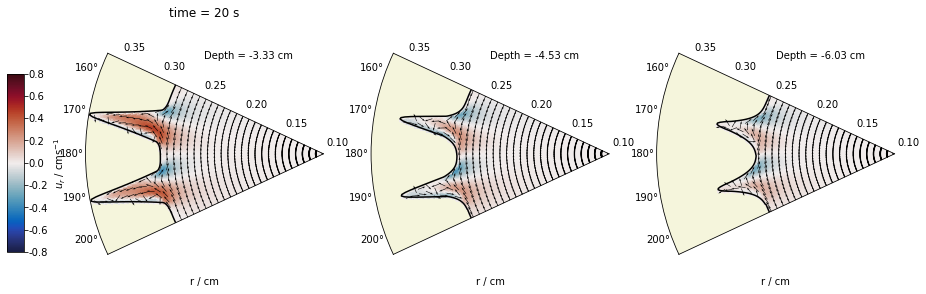

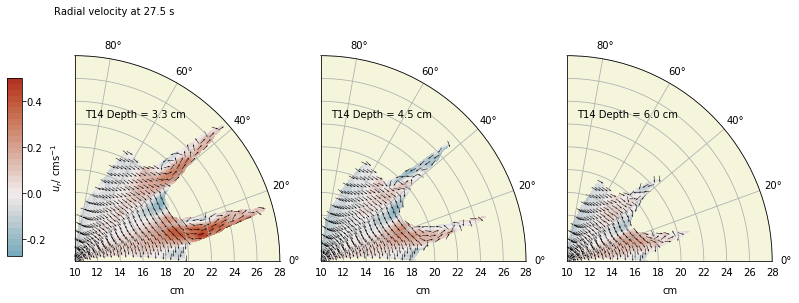

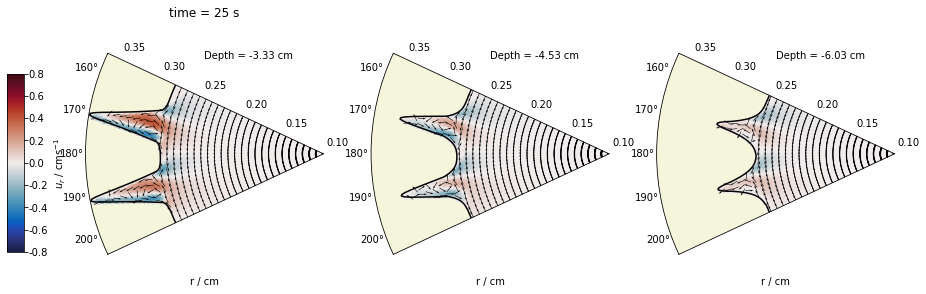

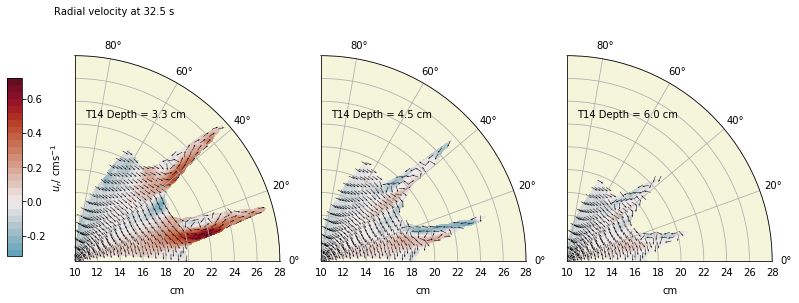

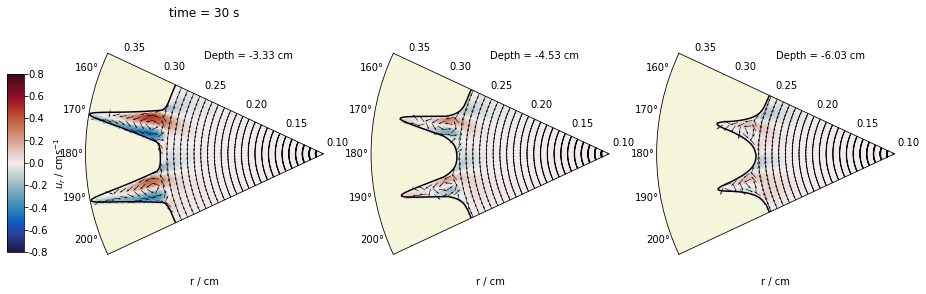

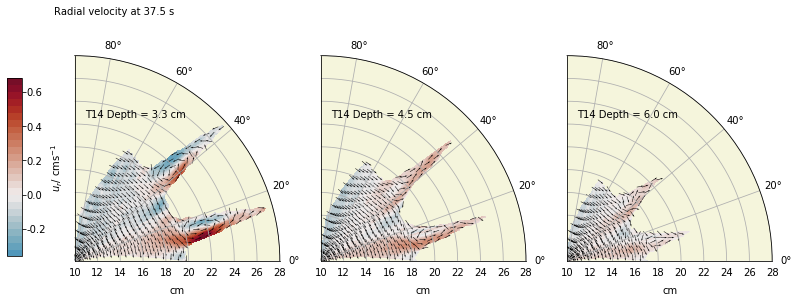

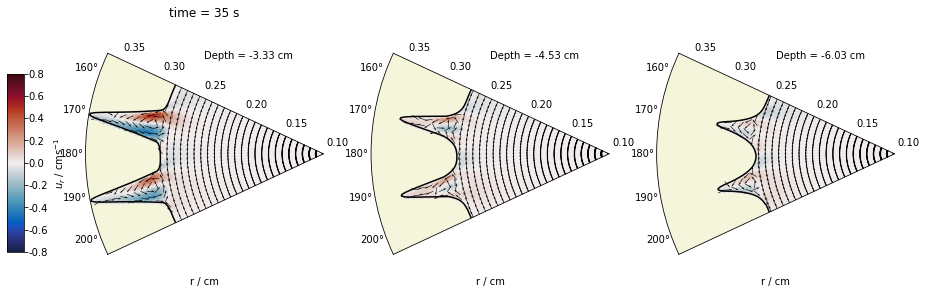

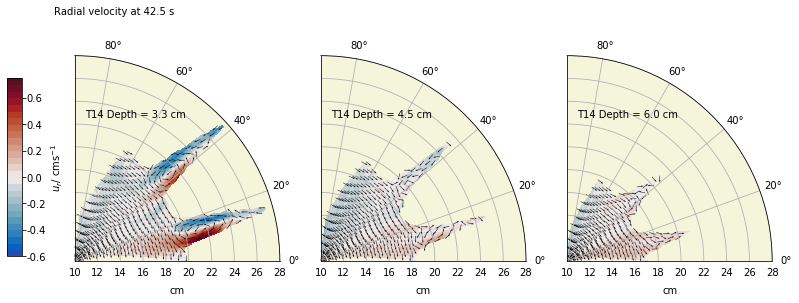

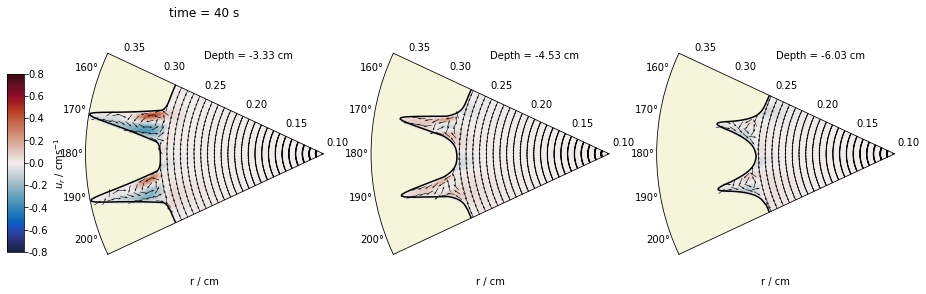

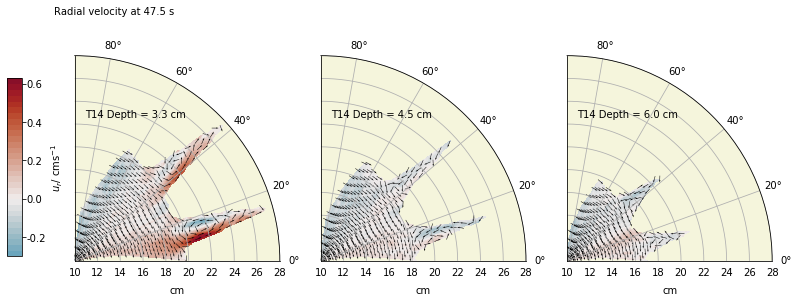

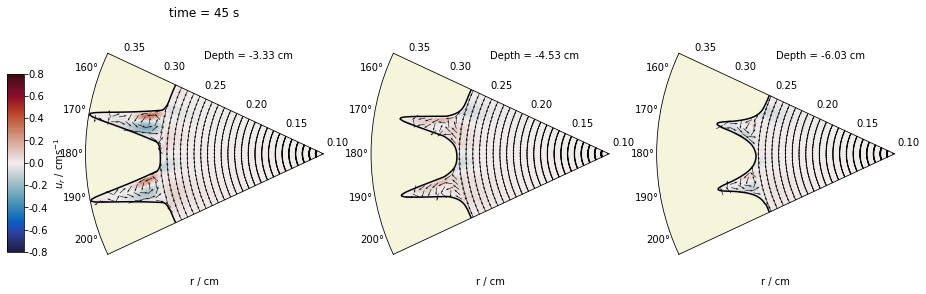

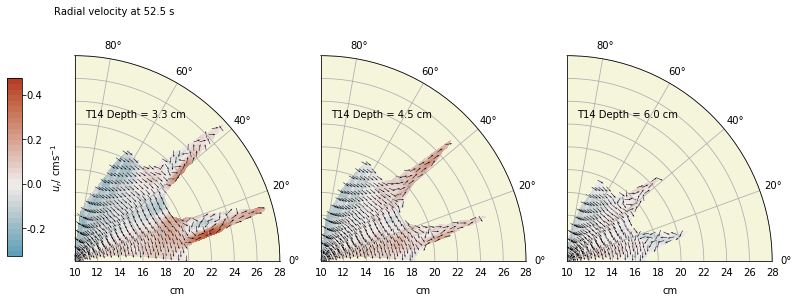

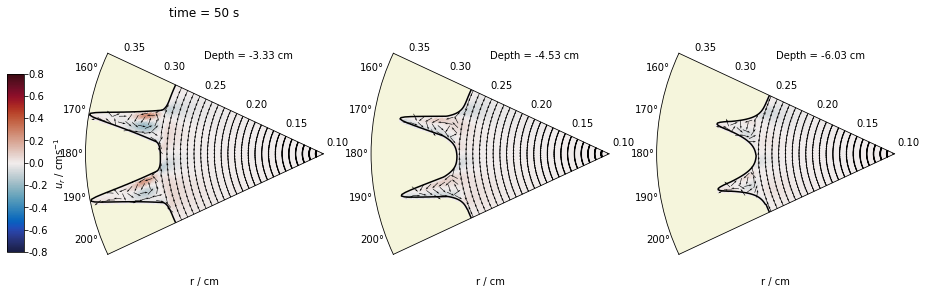

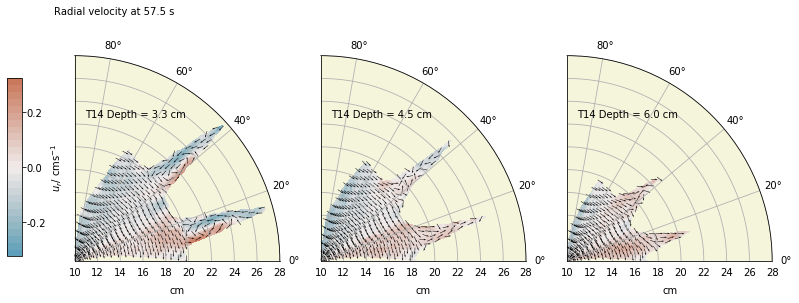

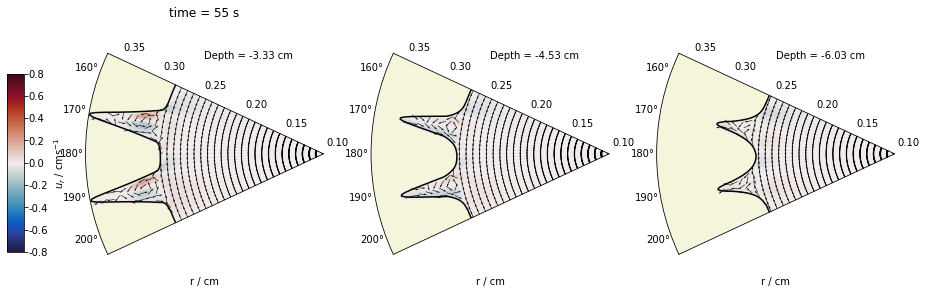

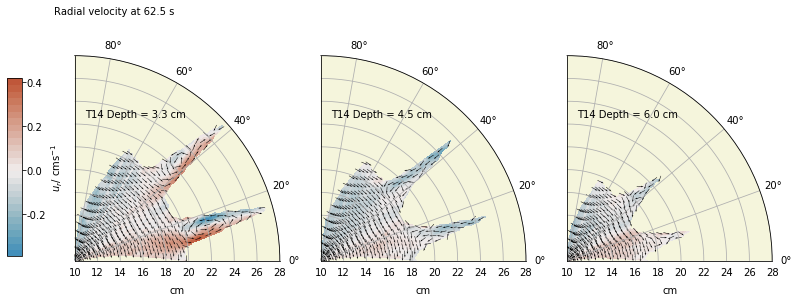

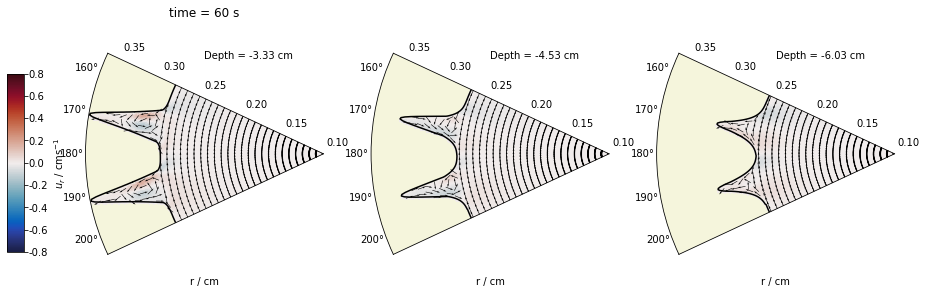

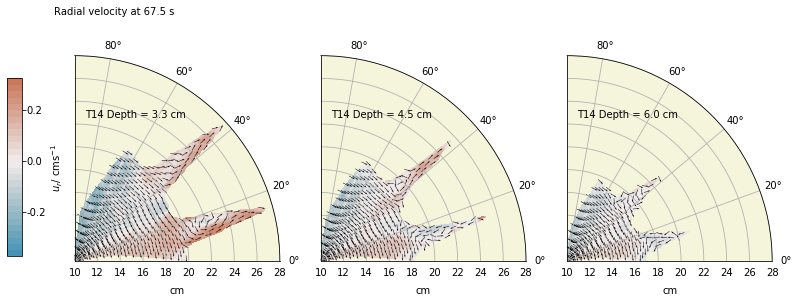

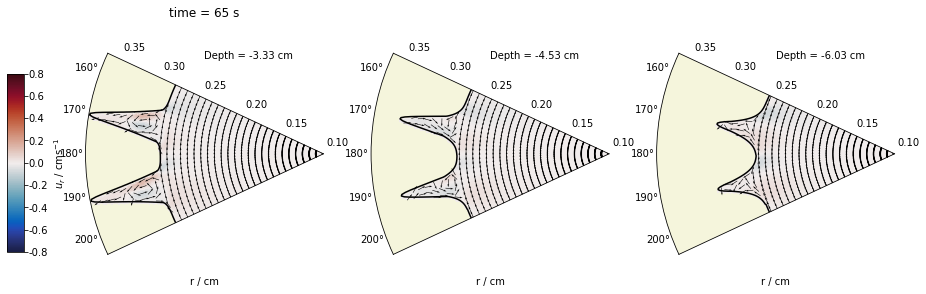

In [151]:
# Normalized quivers - lab 5 min avg vel
max_spd =0.8
min_spd = -0.8
cbar_ticks = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]
nt = 25
frames = np.arange(0,350,nt) # 14 plots

nz1 = int(33/0.5)
nz2 = int(45/0.5)
nz3 = int(60/0.5)
times = range(14)
thmesh, rmesh = np.meshgrid(Th,R)

ur_ups_1_d1 = np.empty(len(times))
ur_dns_1_d1 = np.empty(len(times))
ur_ups_2_d1 = np.empty(len(times))
ur_dns_2_d1 = np.empty(len(times))

ur_ups_1_d2 = np.empty(len(times))
ur_dns_1_d2 = np.empty(len(times))
ur_ups_2_d2 = np.empty(len(times))
ur_dns_2_d2 = np.empty(len(times))

ur_ups_1_d3 = np.empty(len(times))
ur_dns_1_d3 = np.empty(len(times))
ur_ups_2_d3 = np.empty(len(times))
ur_dns_2_d3 = np.empty(len(times))

for tt, fr, ii in zip(times,frames, range(len(times))):
    fig_lab, ax0, ax1, ax2 = plot_lab_rad_vel(max_spd, min_spd, cbar_ticks, fr, mode='avg', nt=nt)
    plt.show()
    fig_model, ax0m, ax1m, ax2m,ur_ups_1, ur_dns_1, ur_ups_2, ur_dns_2,ur2_ups_1, ur2_dns_1, ur2_ups_2, ur2_dns_2,ur3_ups_1, ur3_dns_1, ur3_ups_2, ur3_dns_2= plot_model_rad_vel(tt, thmesh, rmesh, nz1, nz2, nz3,min_spd,max_spd, cbar_ticks)
    ur_ups_1_d1[ii] = ur_ups_1
    ur_dns_1_d1[ii] = ur_dns_1
    ur_ups_2_d1[ii] = ur_ups_2
    ur_dns_2_d1[ii] = ur_dns_2
    
    ur_ups_1_d2[ii] = ur2_ups_1
    ur_dns_1_d2[ii] = ur2_dns_1
    ur_ups_2_d2[ii] = ur2_ups_2
    ur_dns_2_d2[ii] = ur2_dns_2
    
    ur_ups_1_d3[ii] = ur3_ups_1
    ur_dns_1_d3[ii] = ur3_dns_1
    ur_ups_2_d3[ii] = ur3_ups_2
    ur_dns_2_d3[ii] = ur3_dns_2
    plt.show()

(0, 80)

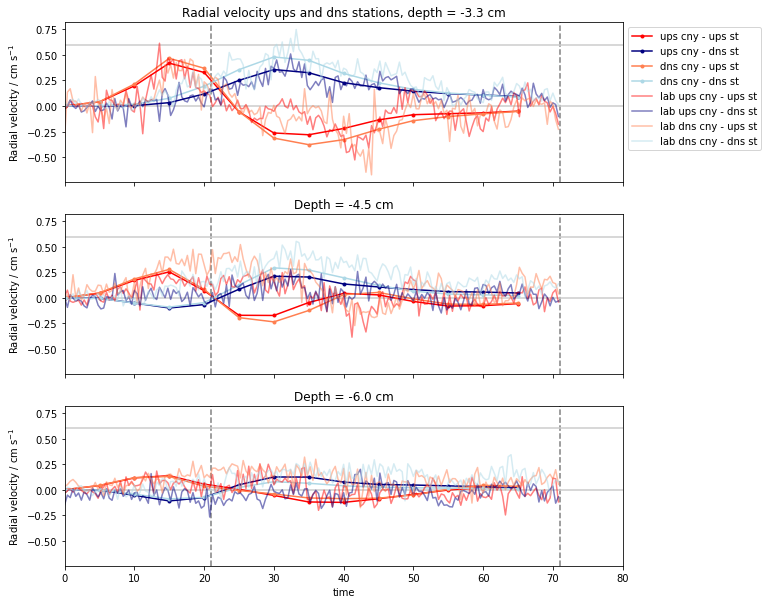

In [157]:
# Plot model vs lab 
nt = 2
times = np.arange(0,356,nt)/5
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)

for ax in [ax0,ax1,ax2]:
    ax.axvline(21, color='0.5', linestyle='--')
    ax.axvline(71, color='0.5', linestyle='--')
    ax.axhline(0,color='0.8')
    ax.axhline(0.6,color='0.8')

# MITgcm depth 1
ax0.plot(np.arange(14)*5, ur_ups_1_d1,'.-',color='red',label='ups cny - ups st')
ax0.plot(np.arange(14)*5, ur_dns_1_d1,'.-',color='navy',label='ups cny - dns st')
ax0.plot(np.arange(14)*5, ur_ups_2_d1,'.-',color='coral',label='dns cny - ups st')
ax0.plot(np.arange(14)*5, ur_dns_2_d1,'.-',color='lightblue',label='dns cny - dns st')

# Lab depth 1
ax0.plot(times, ur_st1_d1,'-',color='red',alpha=0.5,label='lab ups cny - ups st')
ax0.plot(times, ur_st2_d1,'-',color='navy',alpha=0.5,label='lab ups cny - dns st')
ax0.plot(times, ur_st3_d1,'-',color='coral',alpha=0.5,label='lab dns cny - ups st')
ax0.plot(times, ur_st4_d1,'-',color='lightblue',alpha=0.5,label='lab dns cny - dns st')

# MITgcm depth 2
ax1.plot(np.arange(14)*5, ur_ups_1_d2,'.-',color='red',label='ups cny - ups')
ax1.plot(np.arange(14)*5, ur_dns_1_d2,'.-',color='navy',label='ups cny - dns')
ax1.plot(np.arange(14)*5, ur_ups_2_d2,'.-',color='coral',label='dns cny - ups')
ax1.plot(np.arange(14)*5, ur_dns_2_d2,'.-',color='lightblue',label='dns cny - dns')

# Lab depth 2
ax1.plot(times, ur_st1_d2,'-',color='red',alpha=0.5,label='lab ups cny - ups st')
ax1.plot(times, ur_st2_d2,'-',color='navy',alpha=0.5,label='lab ups cny - dns st')
ax1.plot(times, ur_st3_d2,'-',color='coral',alpha=0.5,label='lab dns cny - ups st')
ax1.plot(times, ur_st4_d2,'-',color='lightblue',alpha=0.5,label='lab dns cny - dns st')

# MITgcm depth 3
ax2.plot(np.arange(14)*5, ur_ups_1_d3,'.-',color='red',label='ups cny - ups')
ax2.plot(np.arange(14)*5, ur_dns_1_d3,'.-',color='navy',label='ups cny - dns')
ax2.plot(np.arange(14)*5, ur_ups_2_d3,'.-',color='coral',label='dns cny - ups')
ax2.plot(np.arange(14)*5, ur_dns_2_d3,'.-',color='lightblue',label='dns cny - dns')

# Lab depth 3
ax2.plot(times, ur_st1_d3,'-',color='red',alpha=0.5,label='lab ups cny - ups st')
ax2.plot(times, ur_st2_d3,'-',color='navy',alpha=0.5,label='lab ups cny - dns st')
ax2.plot(times, ur_st3_d3,'-',color='coral',alpha=0.5,label='lab dns cny - ups st')
ax2.plot(times, ur_st4_d3,'-',color='lightblue',alpha=0.5,label='lab dns cny - dns st')

ax2.set_xlabel('time')
ax0.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax1.set_ylabel(r'Radial velocity / cm s$^{-1}$')
ax2.set_ylabel(r'Radial velocity / cm s$^{-1}$')

ax0.set_title('Radial velocity ups and dns stations, depth = %1.1f cm' %( 100*RC[nz1]))
ax1.set_title('Depth = %1.1f cm' %( 100*RC[nz2]))
ax2.set_title('Depth = %1.1f cm' %( 100*RC[nz3]))

ax0.legend(bbox_to_anchor=(1,1))
ax0.set_xlim(0,80)

In [2]:
80/0.005


16000.0